# Crear un modelo de machine learning para predecir probabilidades de cancelación y crear clústers de usuarios
**Problema**: Pérdida de clientes -> calcular la pérdida. <span style="color: gold;">**Se define como pérdida cuando no viene en 1 mes**</span>.

**Tarea**: Elaborar una estrategia de retención de clientes.

**Pasos a seguir**
1) Predecir la probabilidad de pérdida
2) Elaborar y analizar clústers de usuarios 
3) Analizar factores que más impactan en la pérdida de clientes
4) Realizar recomendaciones
    * identificar a los grupos objetivo;
    * sugerir medidas para reducir la rotación;
    * describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## Diccionario de datos
* ``'Churn'`` — la cancelación para el mes en cuestión
* ``'gender'`` — género
* ``'Near_Location'`` — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
* ``'Partner'`` — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
* ``'Promo_friends'`` — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
* ``'Phone'`` — si el/la usuario/a aportó el número de teléfono.
* ``'Age'`` — edad.
* ``'Lifetime'`` — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.
* ``'Contract_period'`` — 1 mes, 3 meses, 6 meses o 1 año.
* ``'Month_to_end_contract'`` — los meses que faltan hasta que expire el contrato.
* ``'Group_visits'`` — si el/la usuario/a participa en sesiones grupales.
* ``'Avg_class_frequency_total'`` — frecuencia media de visitas por semana a lo largo de la vida del cliente.
* ``'Avg_class_frequency_current_month'`` — frecuencia media de visitas por semana durante el mes en curso.
* ``'Avg_additional_charges_total'`` — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [1]:
# importar librerías 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

In [2]:
# cargar dataset
gym_data = pd.read_csv('gym_churn_us.csv')

In [3]:
# formato de gráficos
plt.style.use('dark_background')

# EDA

In [4]:
# información general
gym_data.info()
print('\n', gym_data.sample(5))
print('\n', 'Hay', gym_data.duplicated().sum(), 'valores duplicados')

# formatear nombres de columnas
gym_data.columns = gym_data.columns.str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# descriptivos del dataframe
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
# medias de usuarios con cancelación y usuarios activos
means = gym_data.groupby('churn')[gym_data.columns].mean()
means

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
churn,,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0


In [7]:
# dividir en grupos: usuarios activos, usuarios con cancelación
active_users = gym_data.query('churn == 1')
canceled_users = gym_data.query('churn == 0')

Usuarios activos: 1061
Usuarios cancelados: 2939


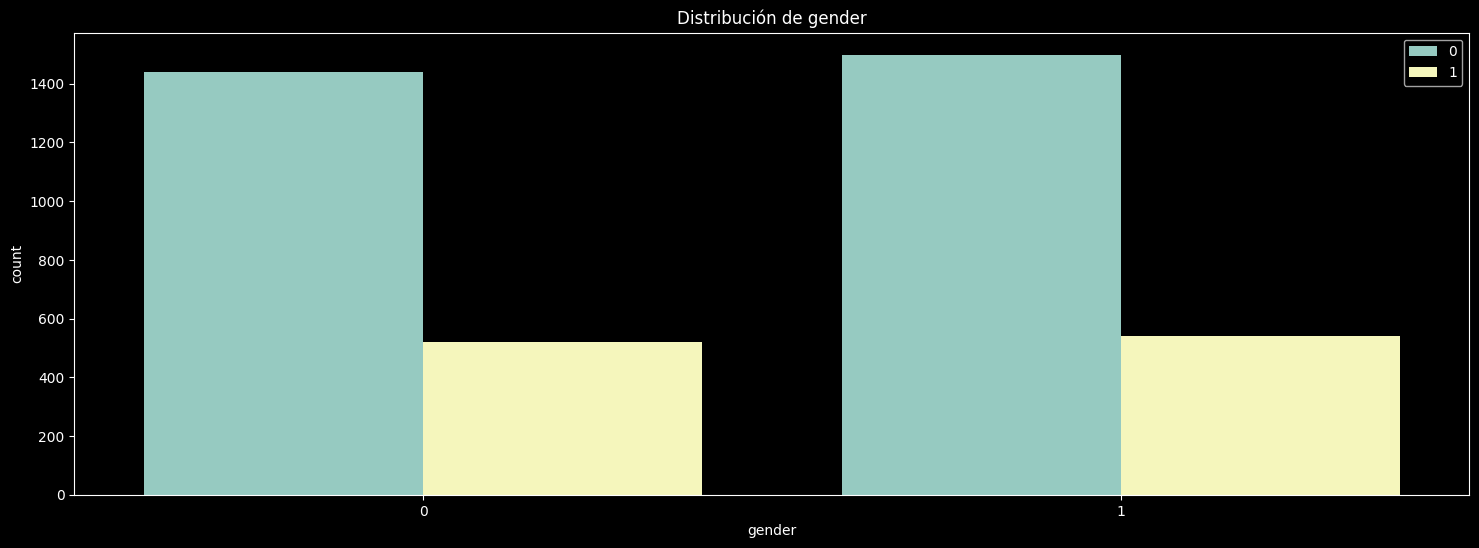

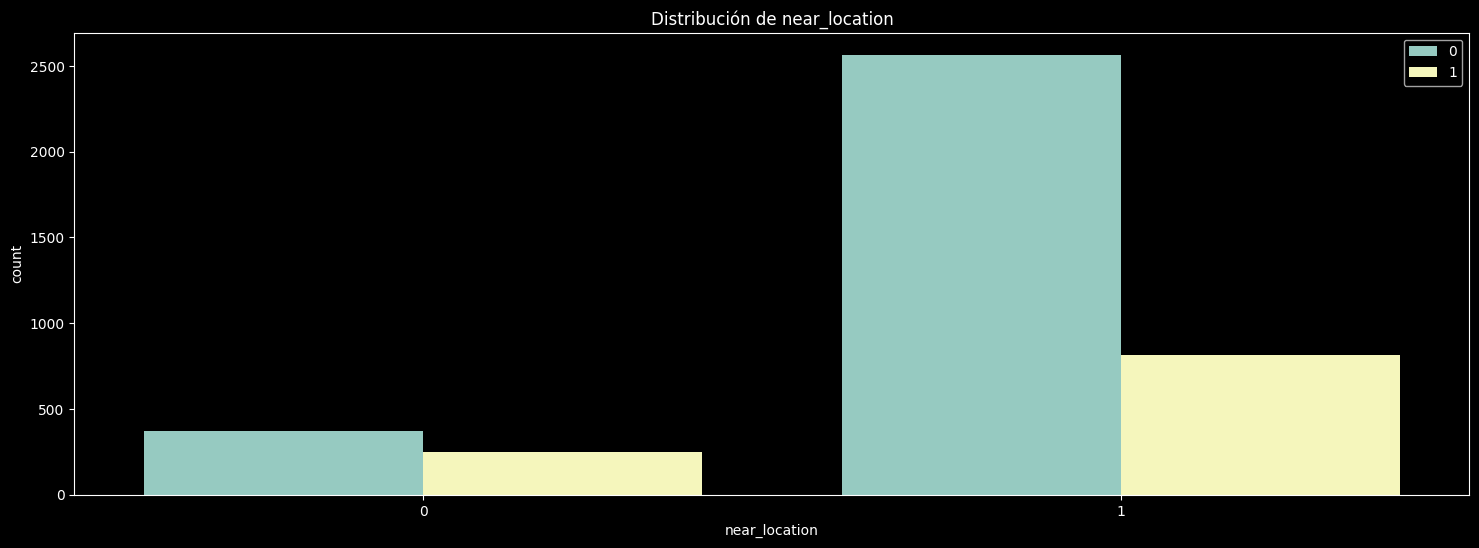

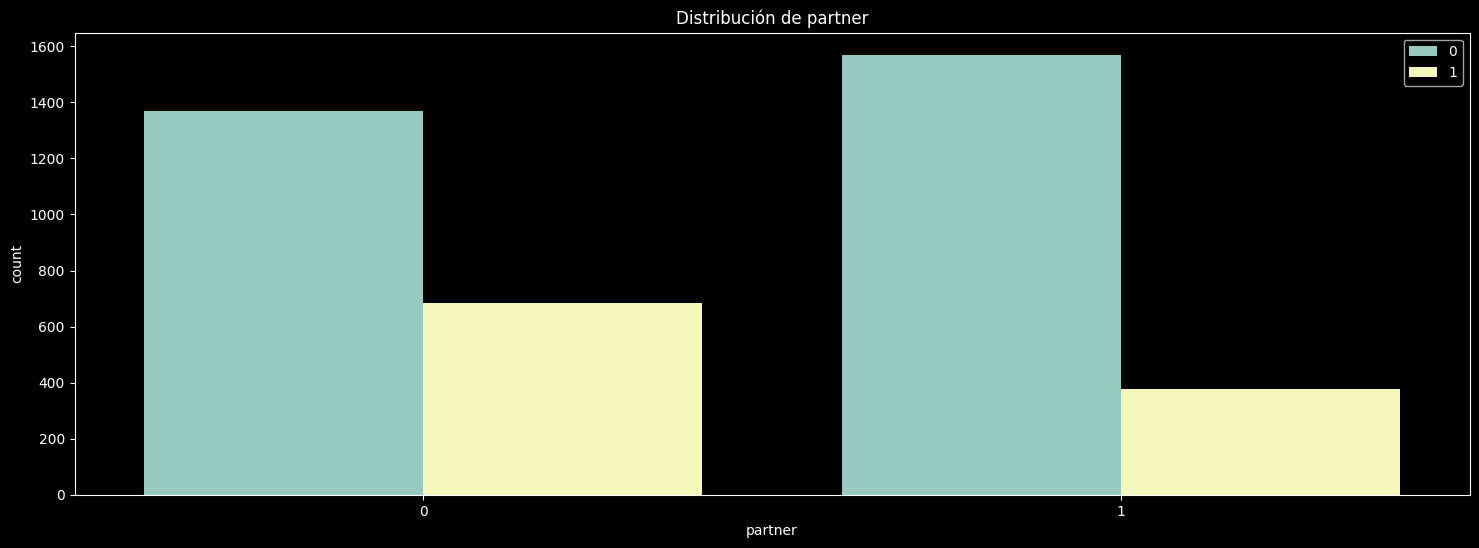

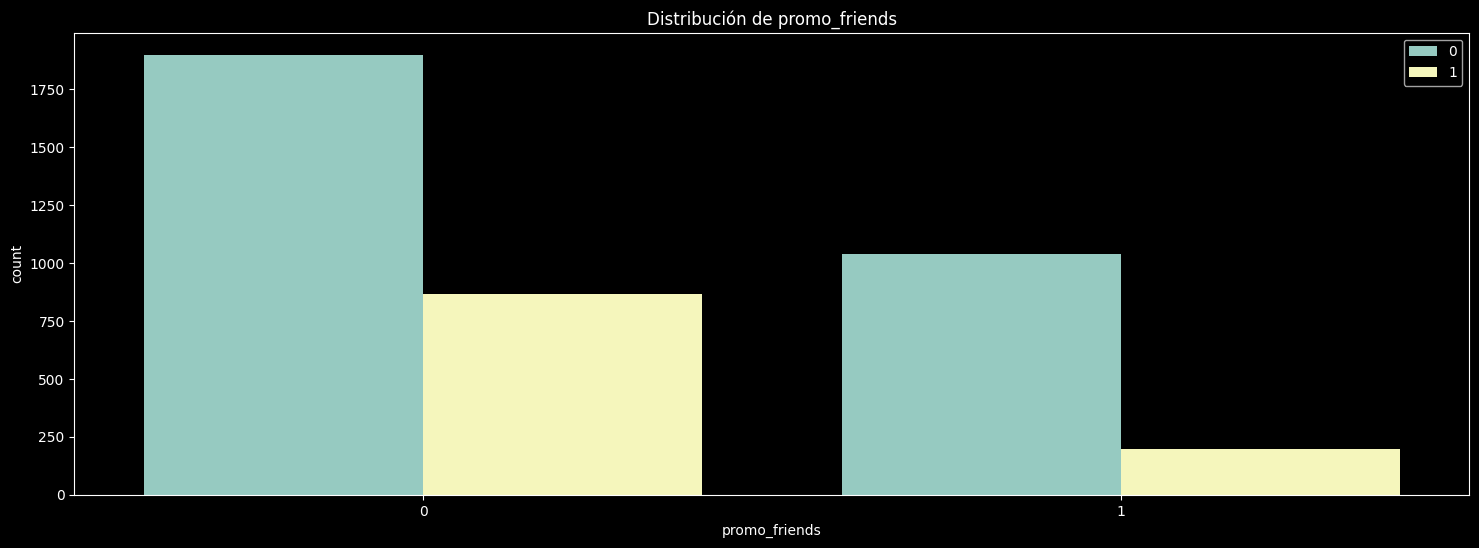

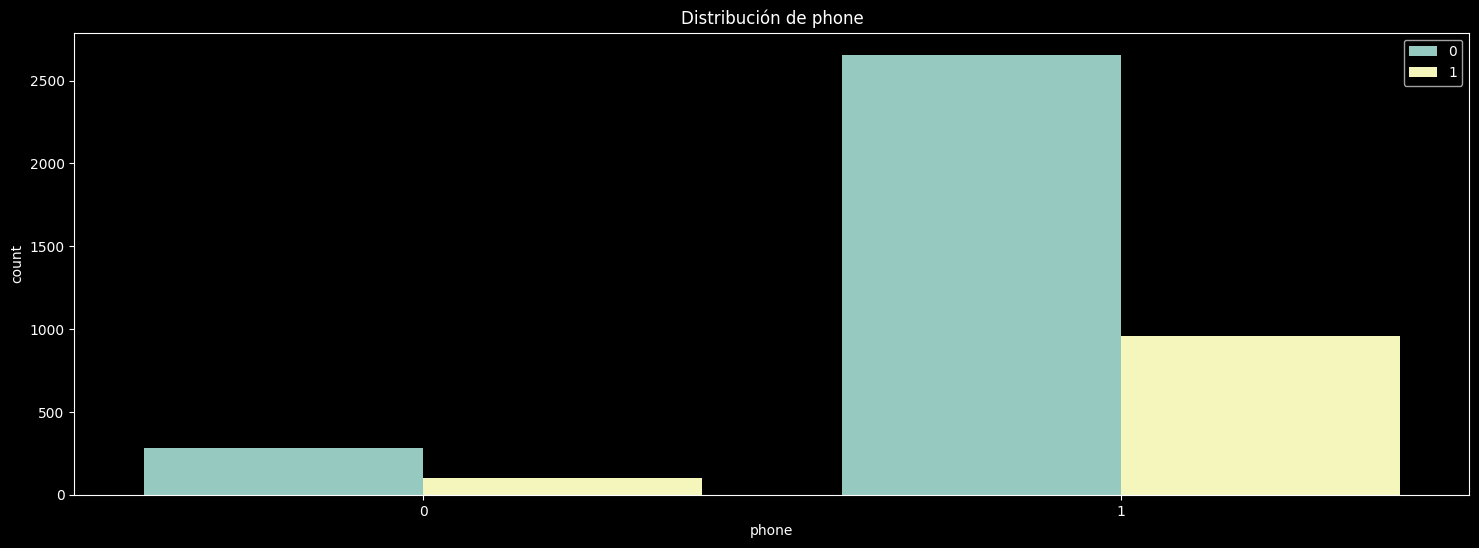

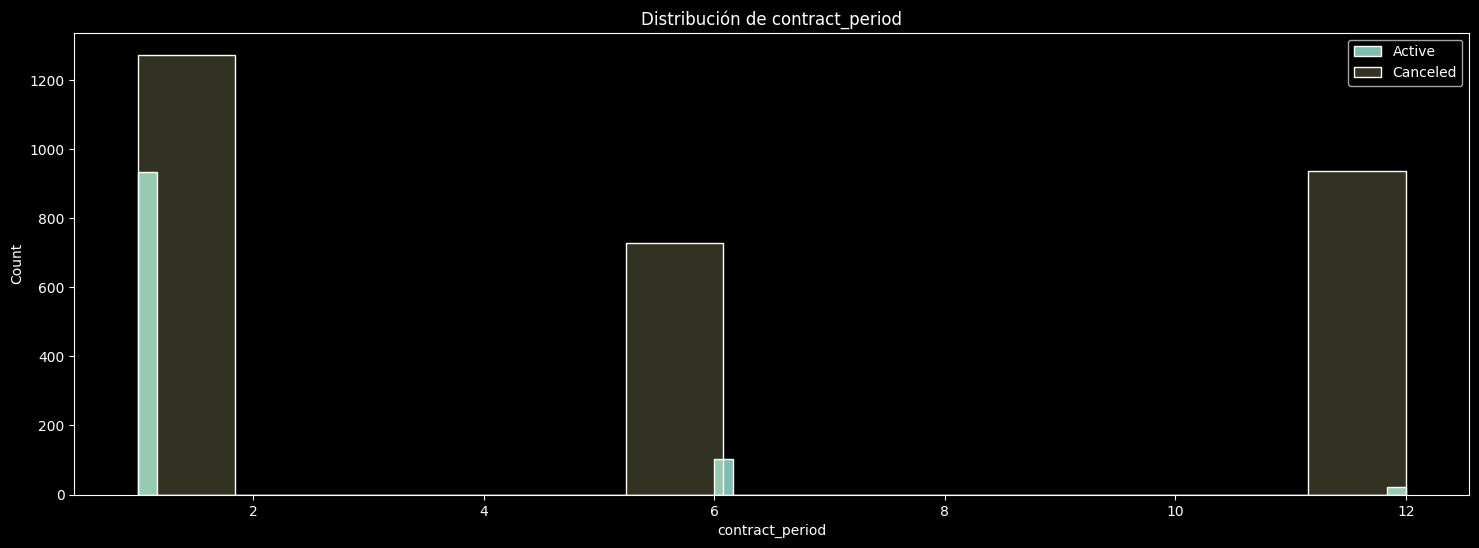

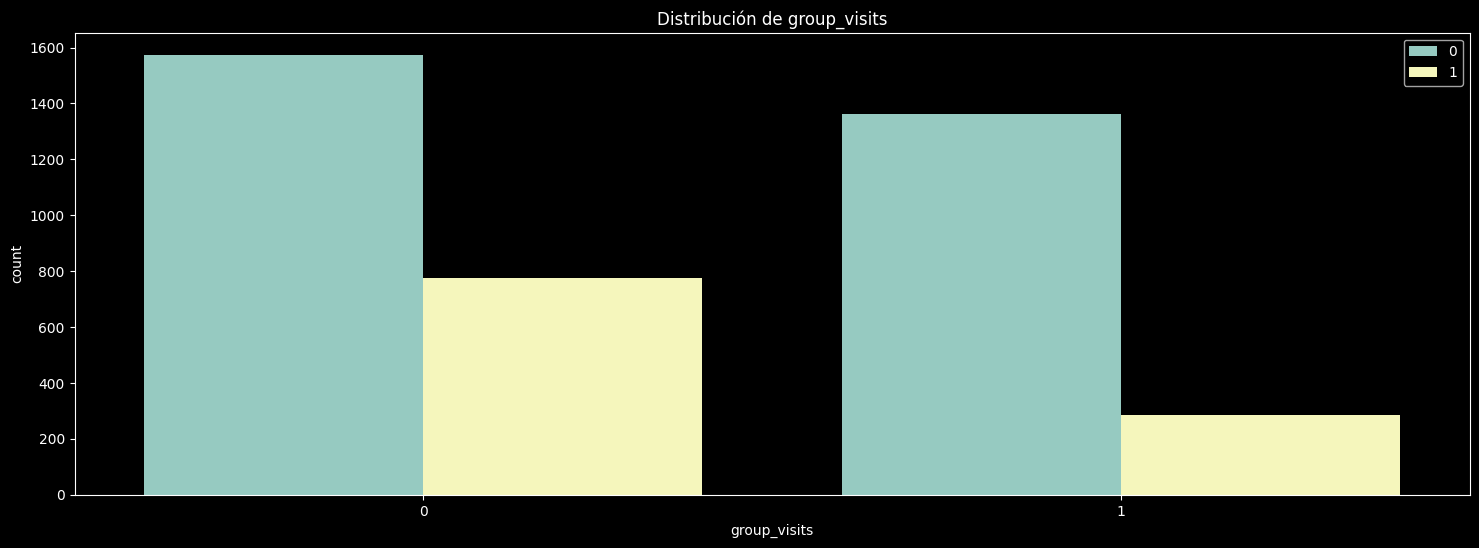

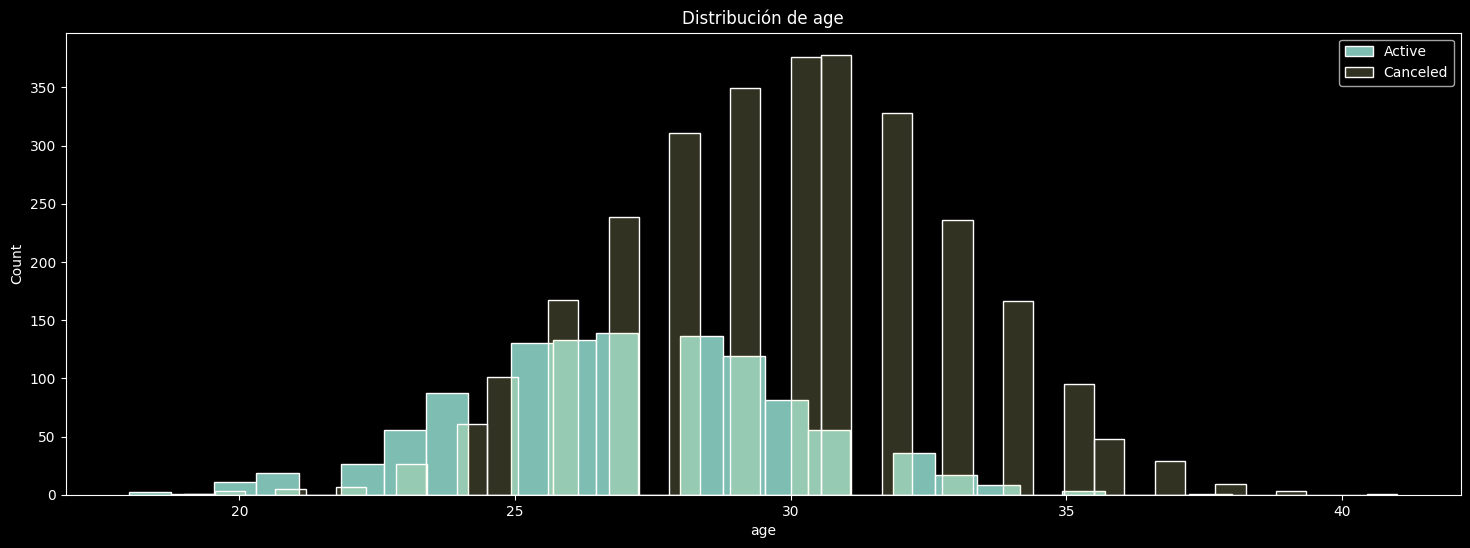

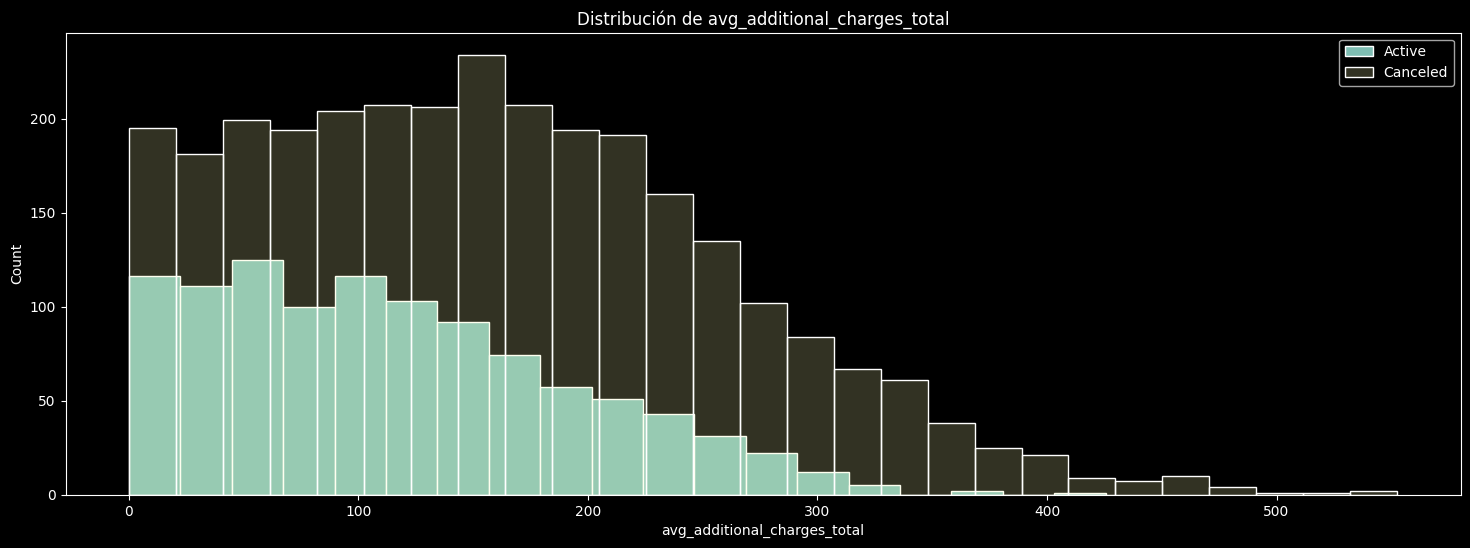

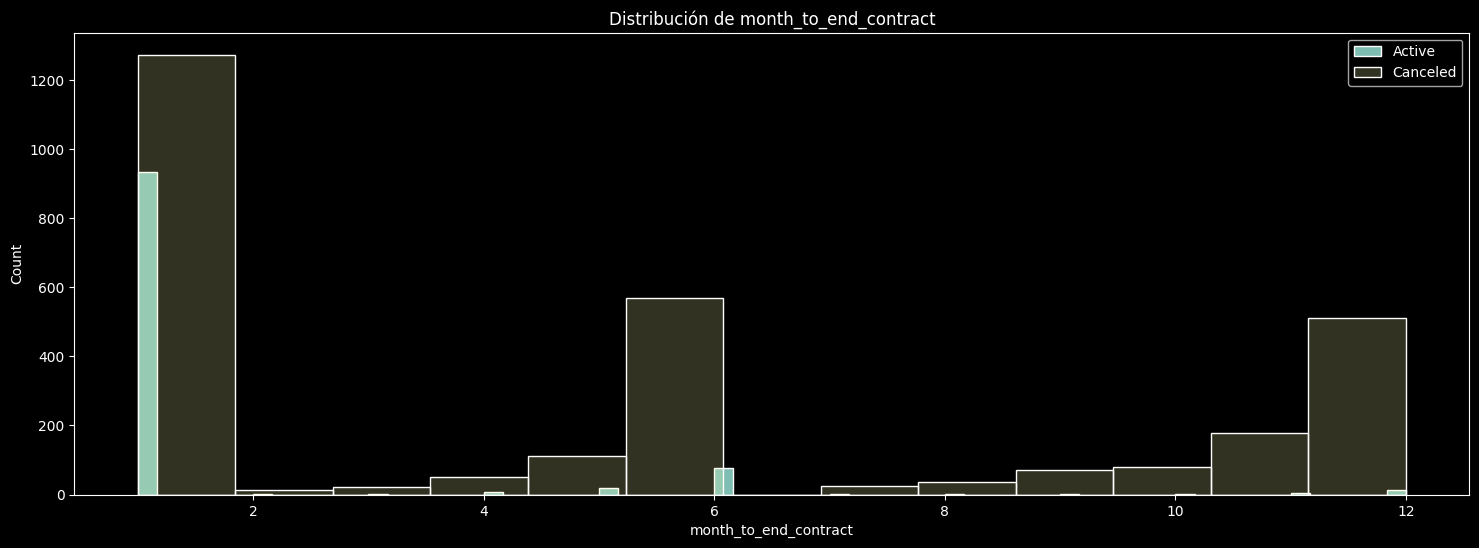

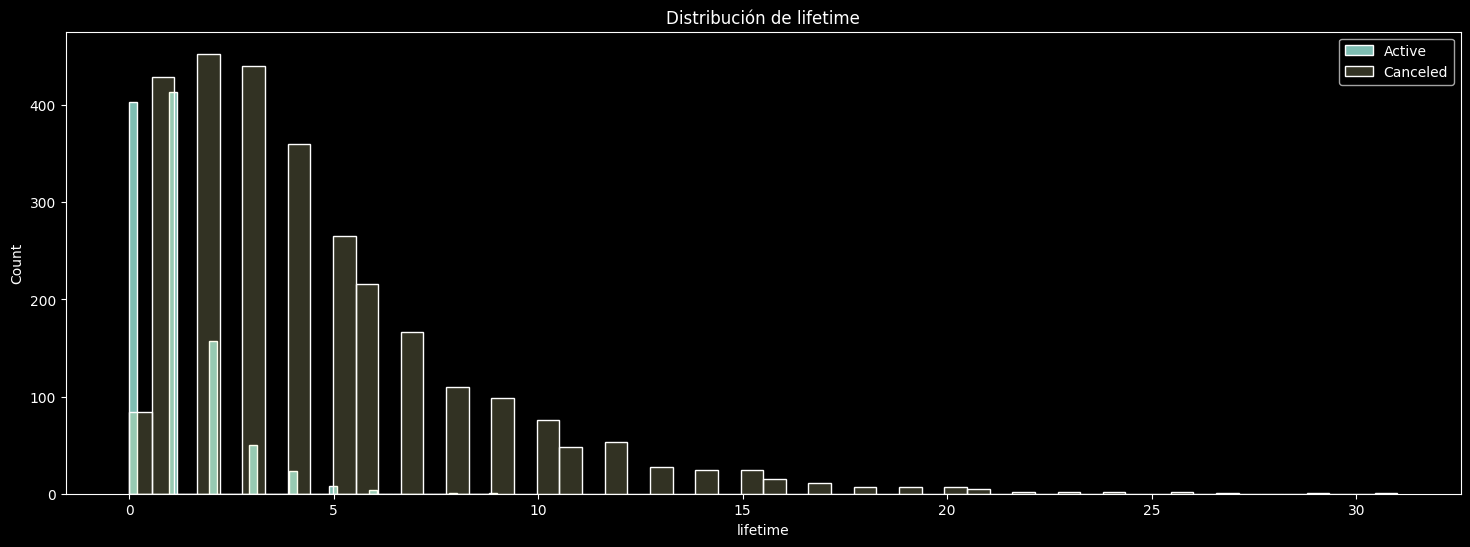

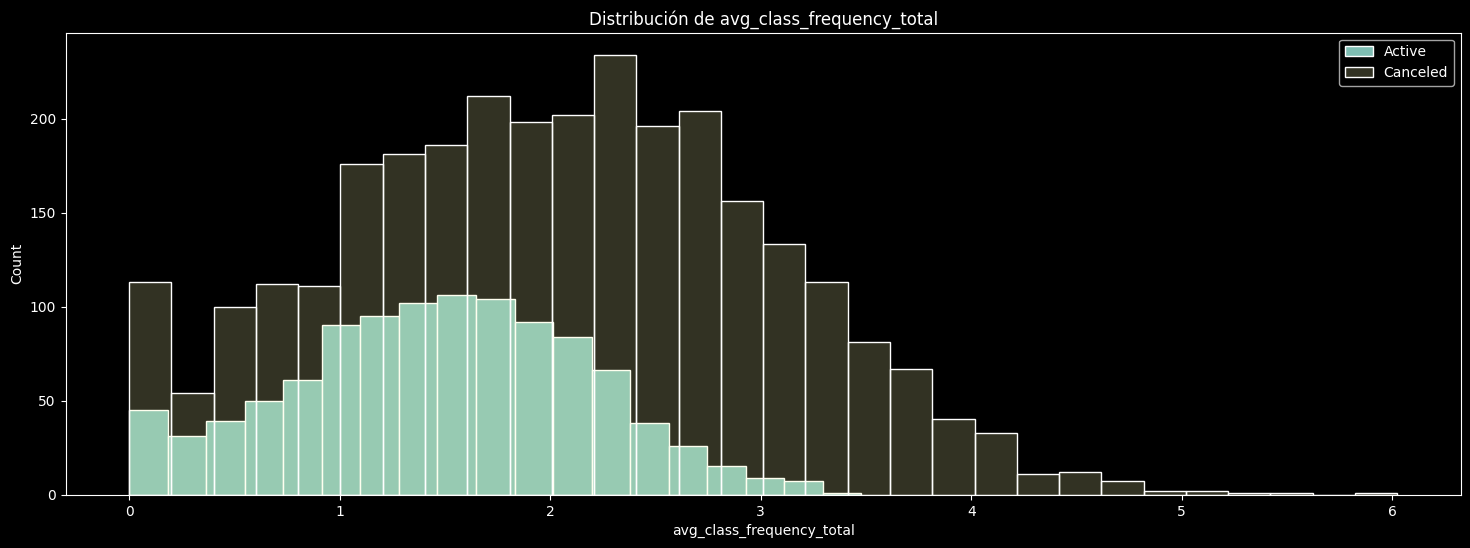

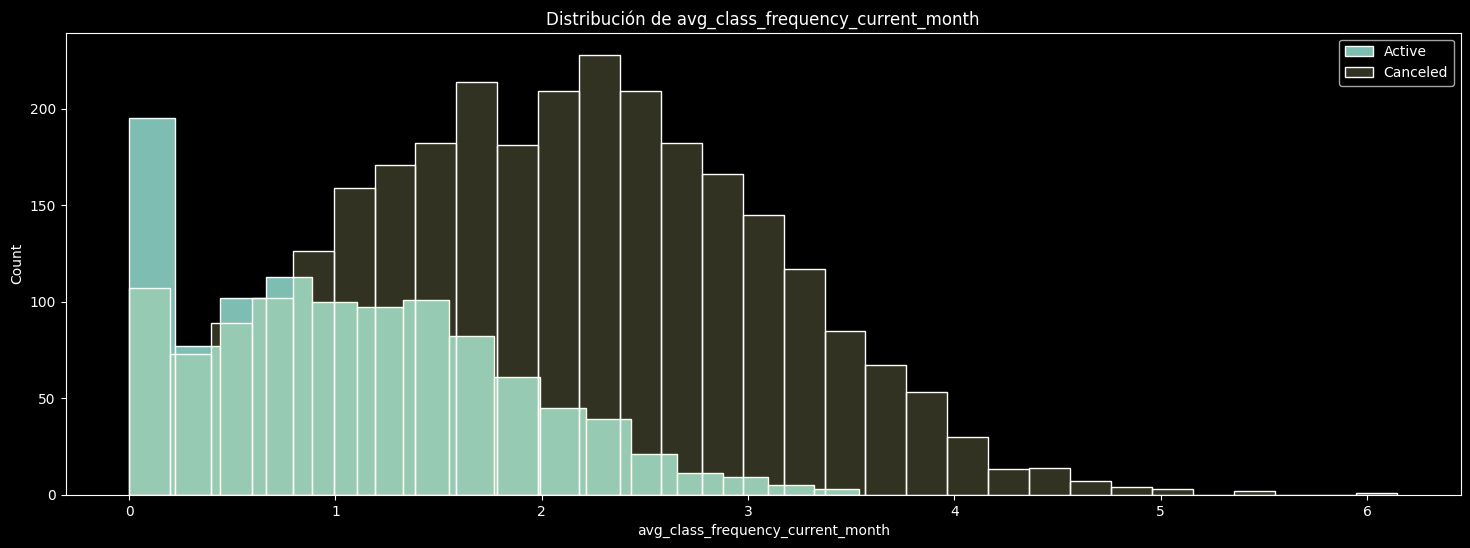

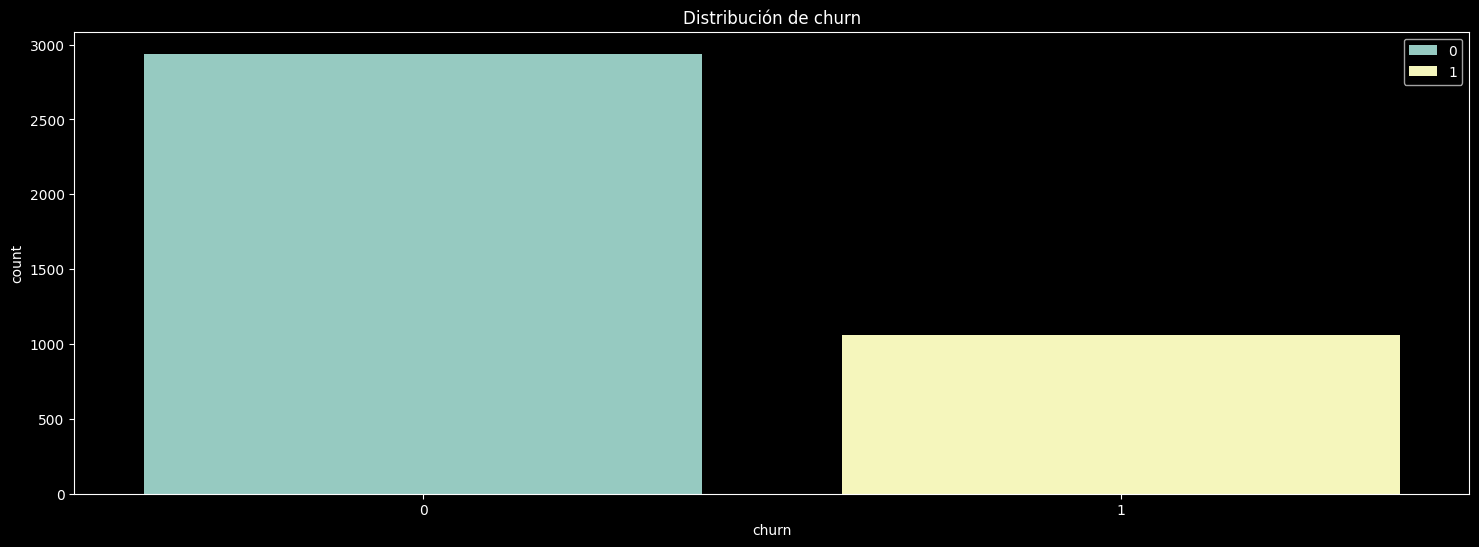

In [8]:
# crear histogramas
characteristics = gym_data.columns.to_list()
print('Usuarios activos:', active_users.shape[0])
print('Usuarios cancelados:', canceled_users.shape[0])

for character in characteristics:
    plt.figure(figsize=(18,6))
    # Gráfica para variables categóricas
    if gym_data[character].nunique() <= 2:
        sns.countplot(data=gym_data, x=character, hue='churn')
    
    # Gráfica para numéricas
    else:
        sns.histplot(active_users[character], label="Active", alpha=0.9)
        sns.histplot(canceled_users[character], label="Canceled", alpha=0.2)

    plt.title(f"Distribución de {character}")
    plt.legend()
    plt.show()

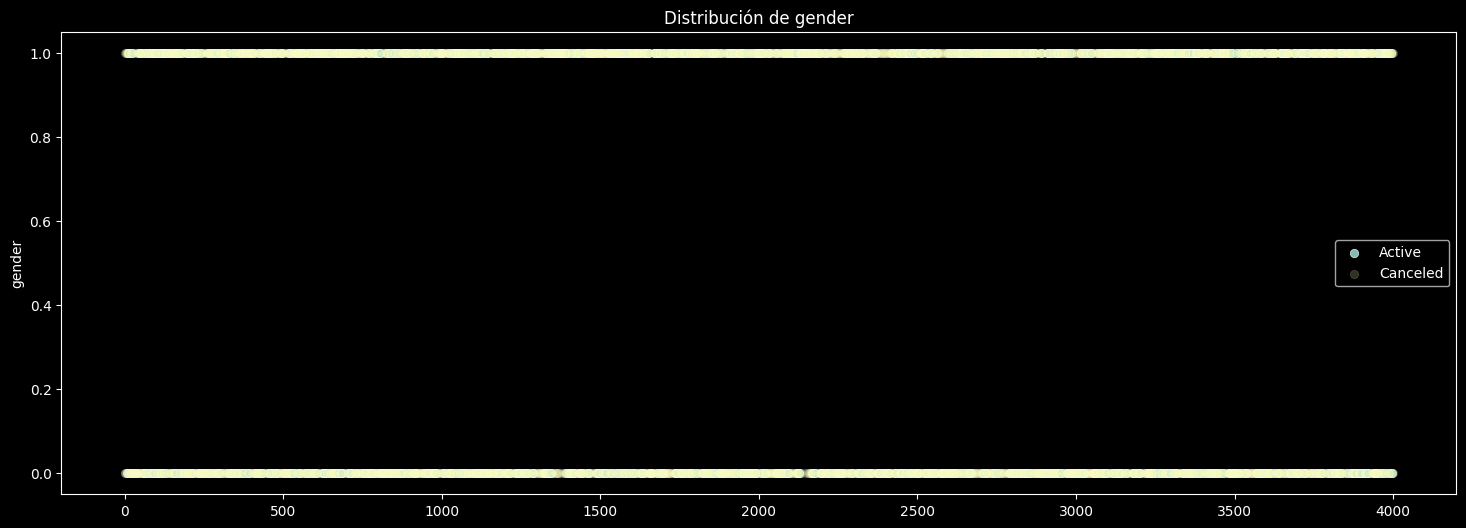

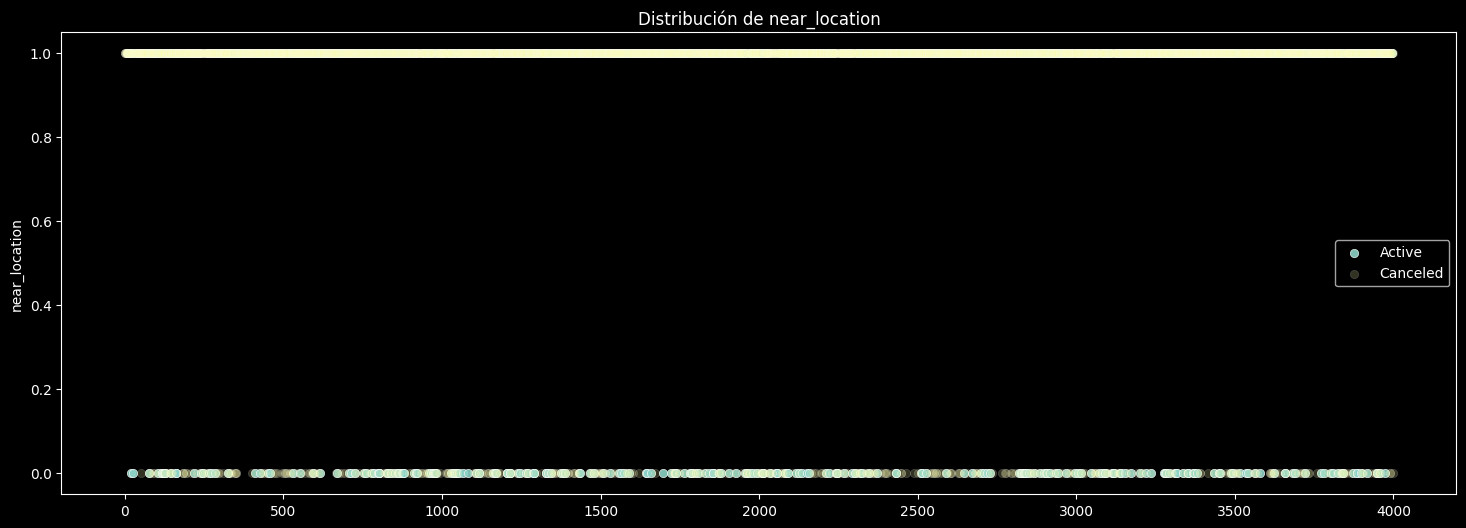

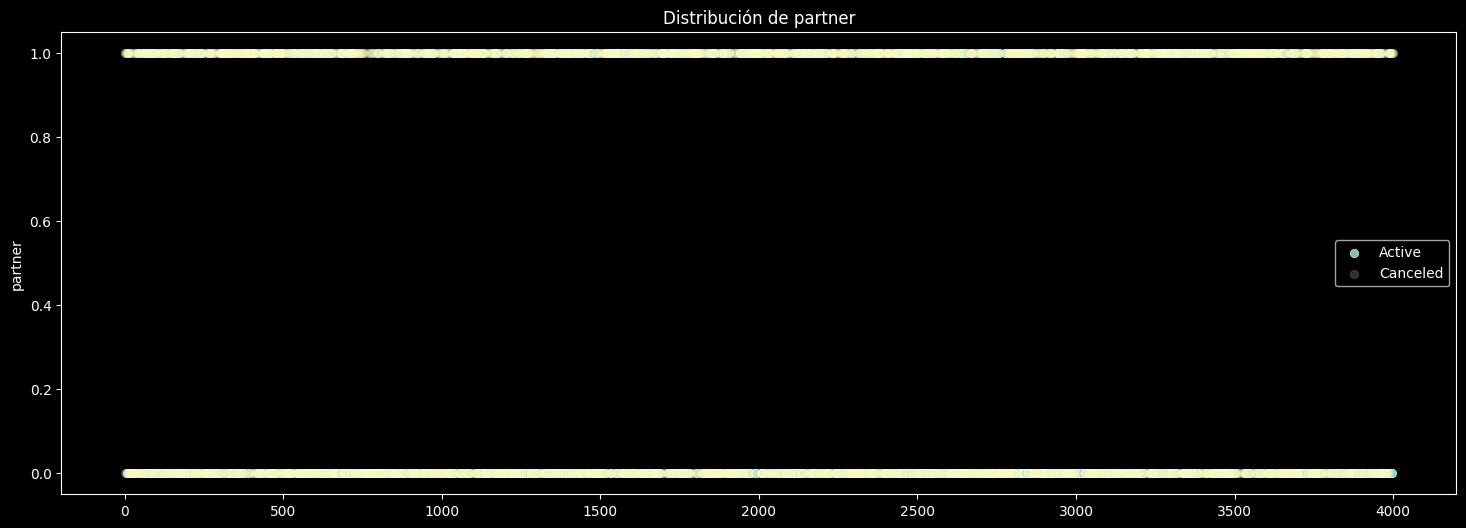

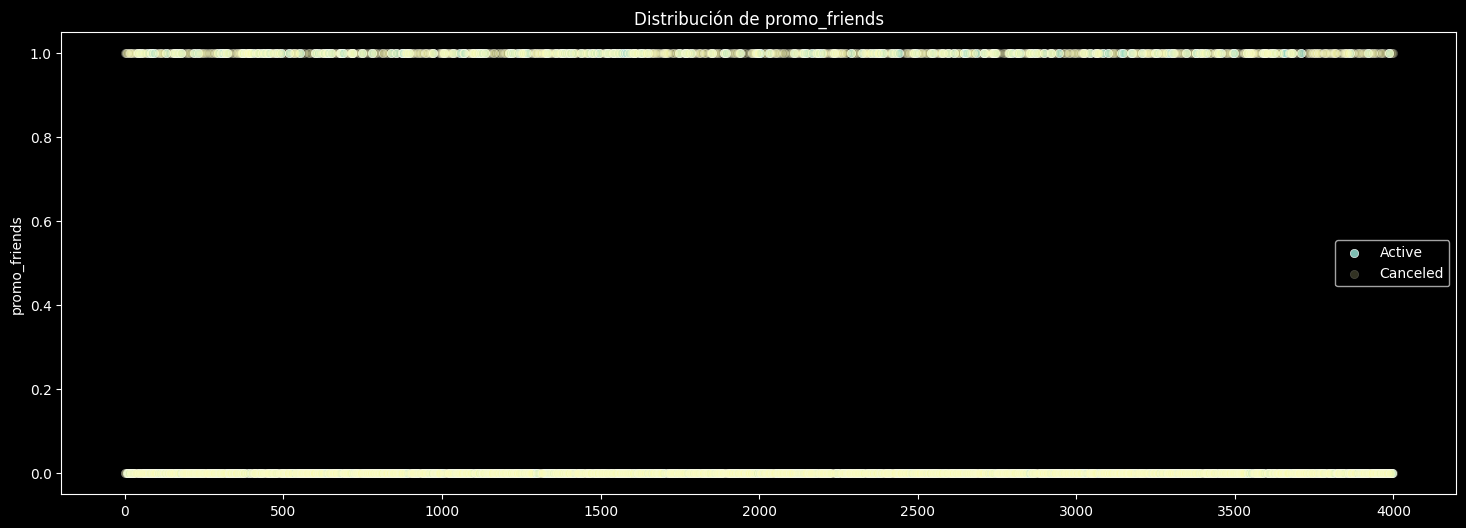

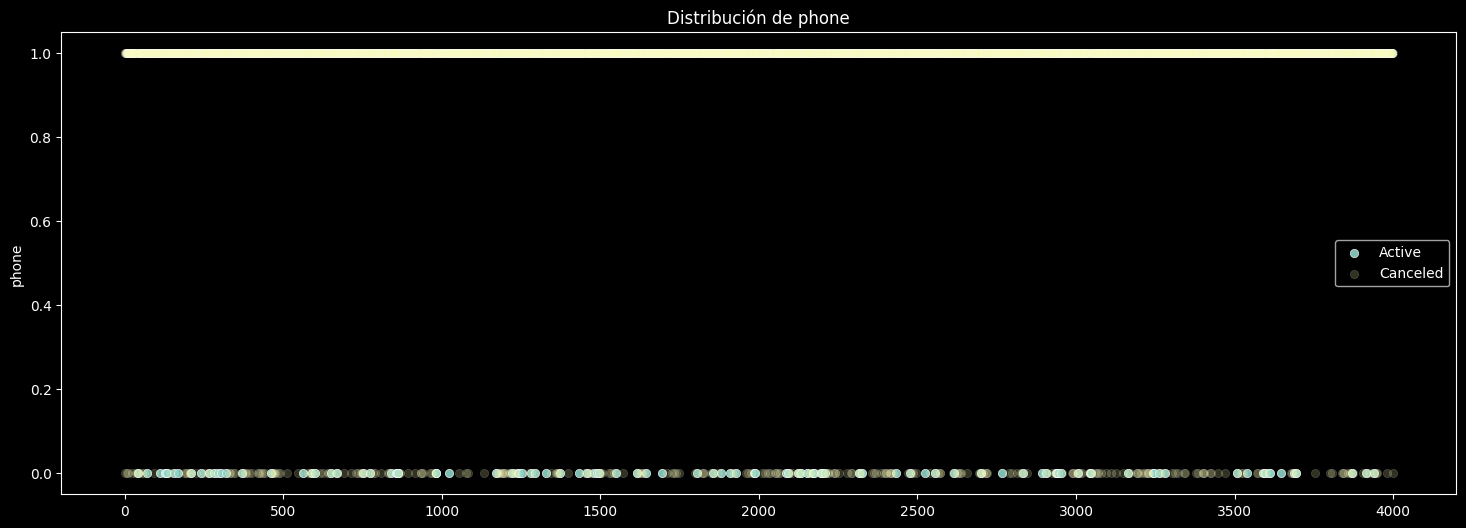

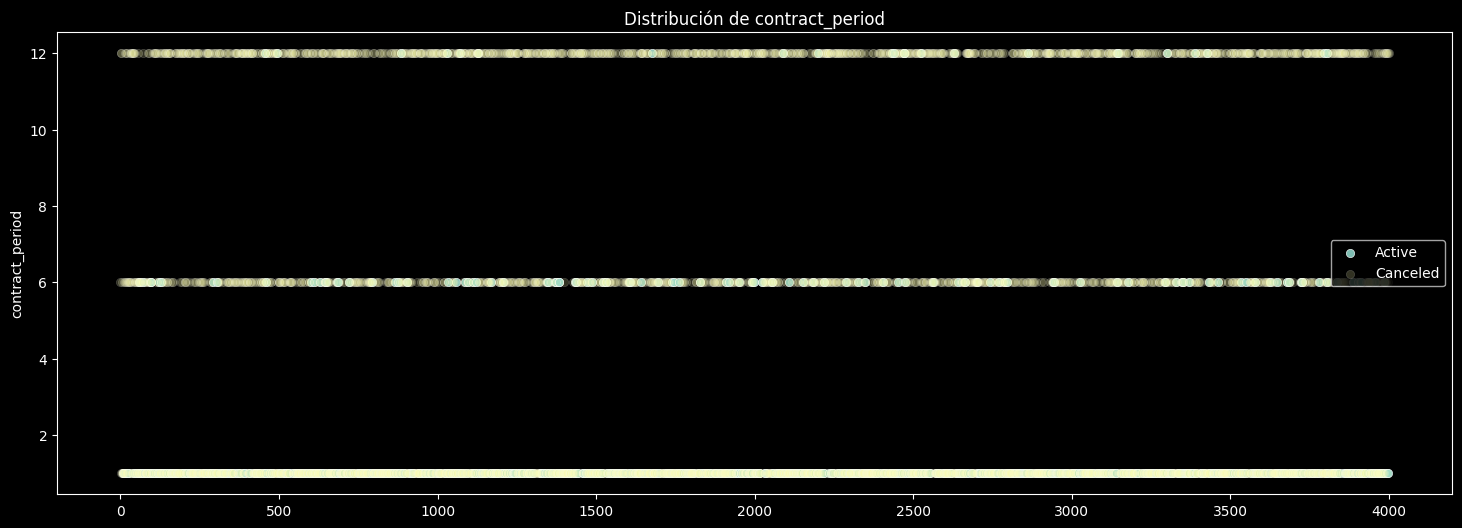

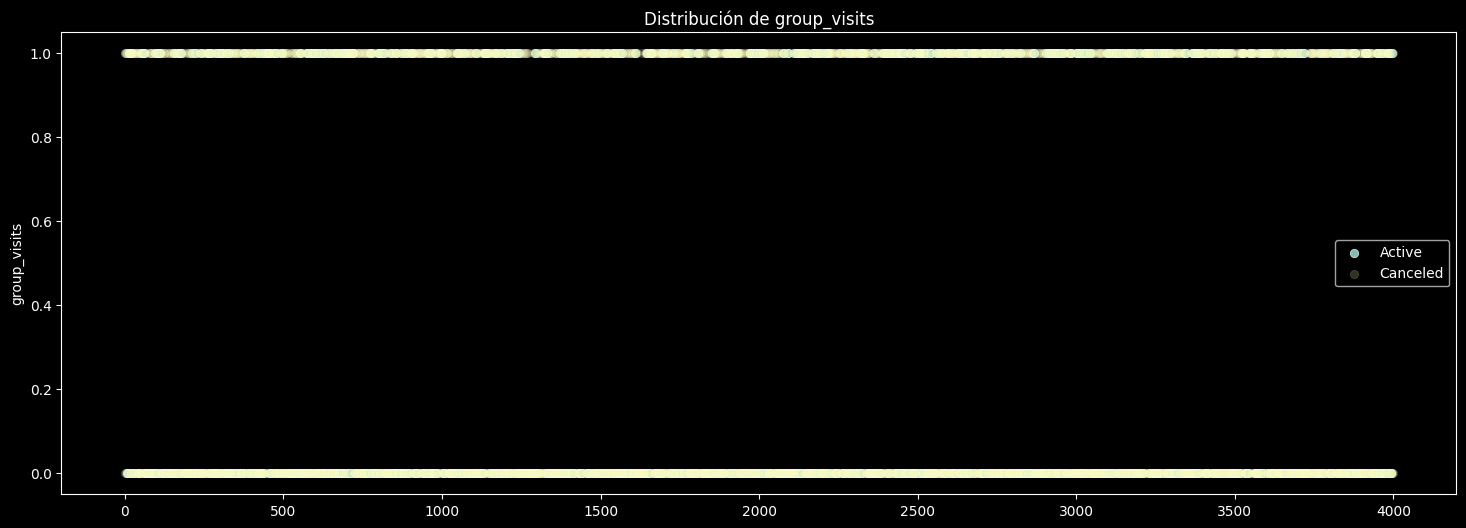

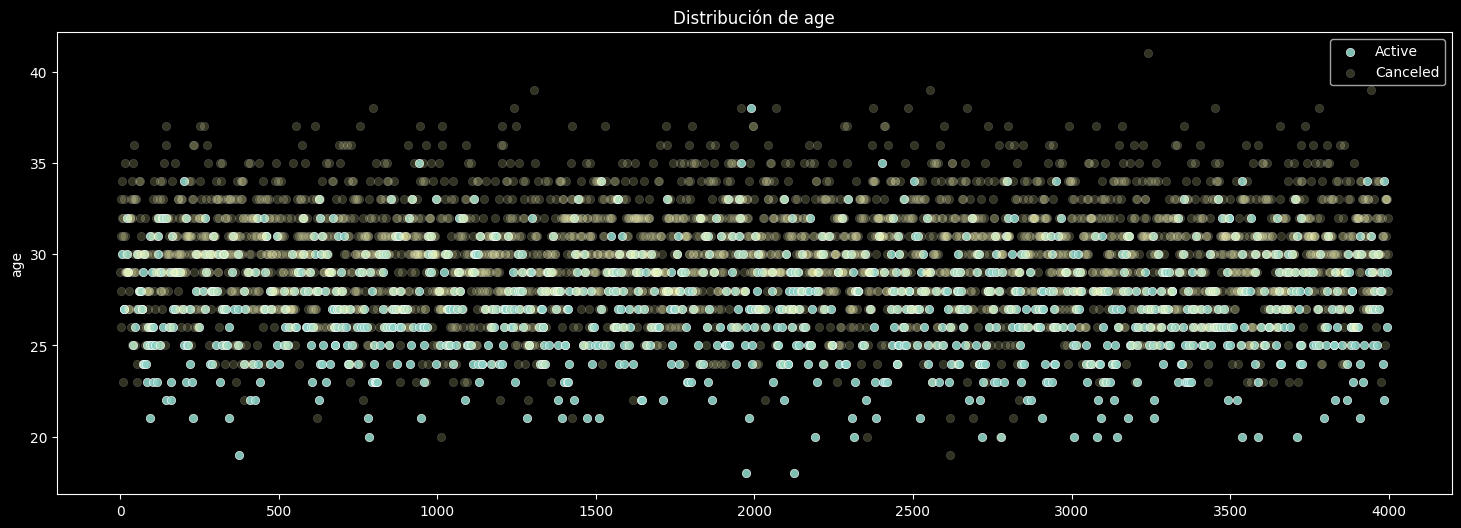

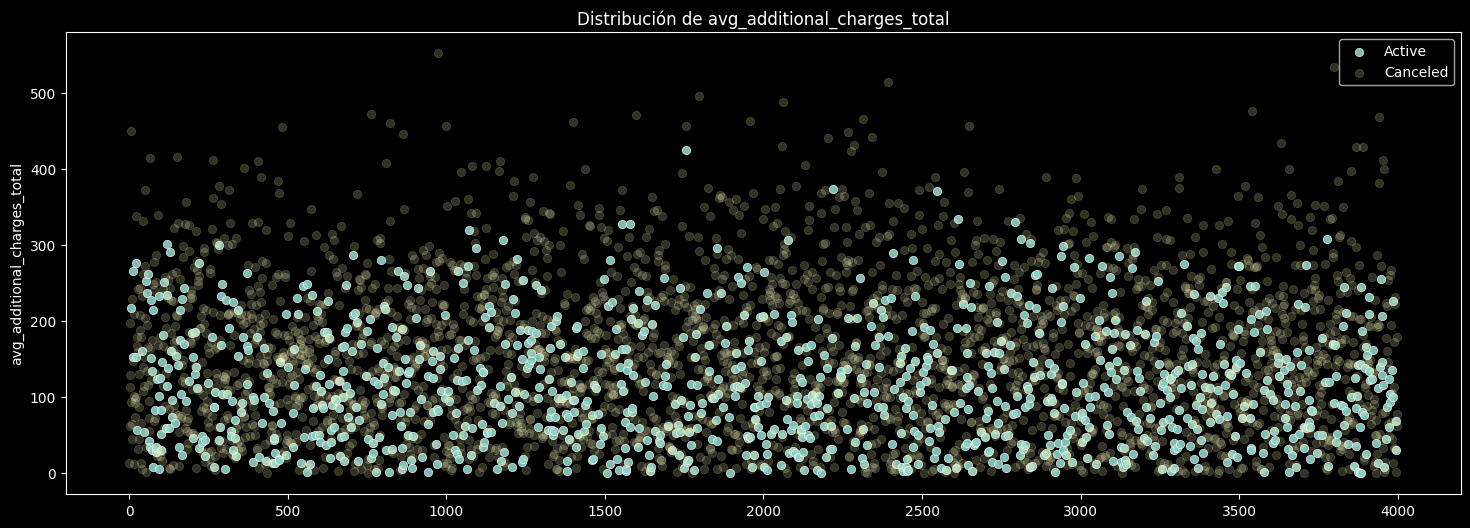

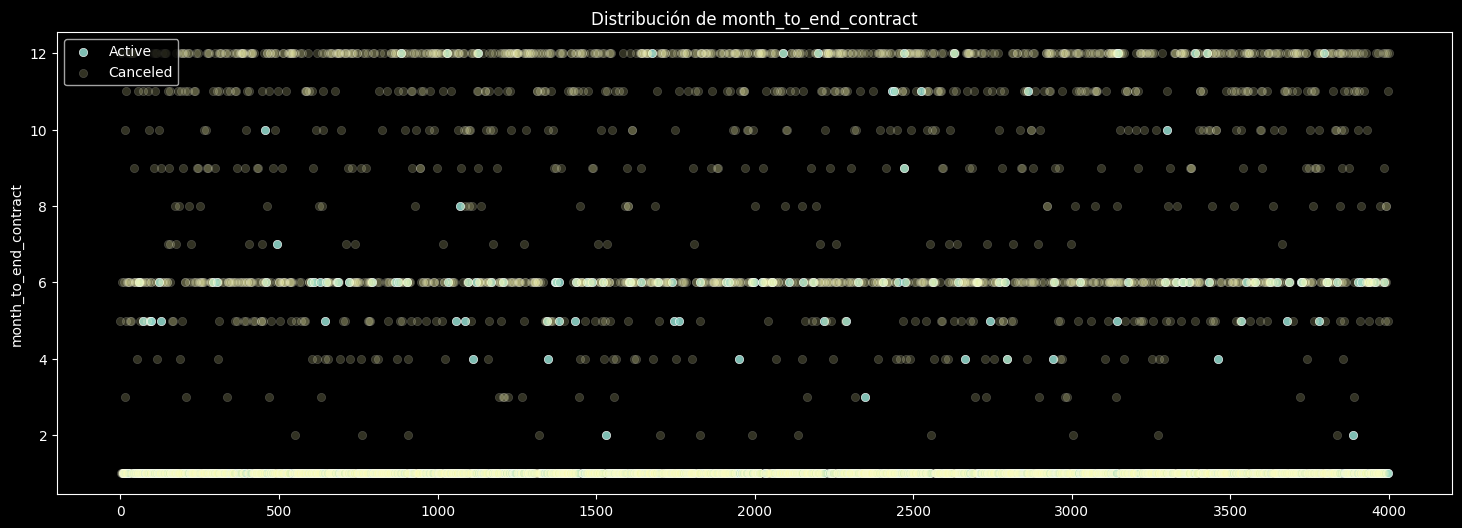

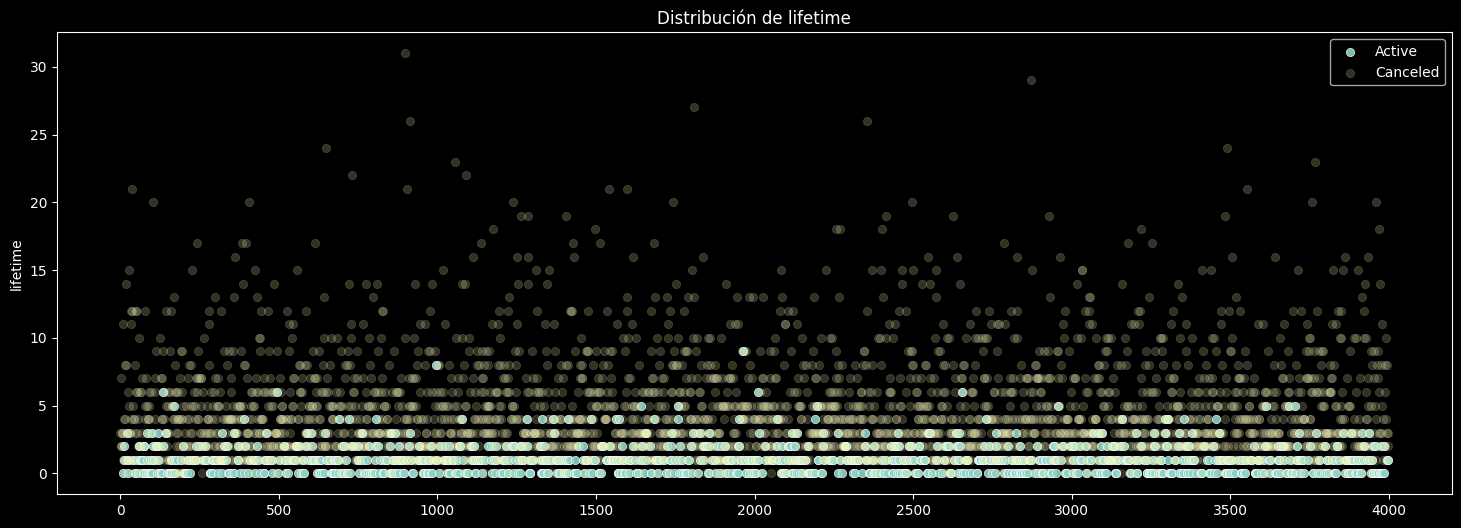

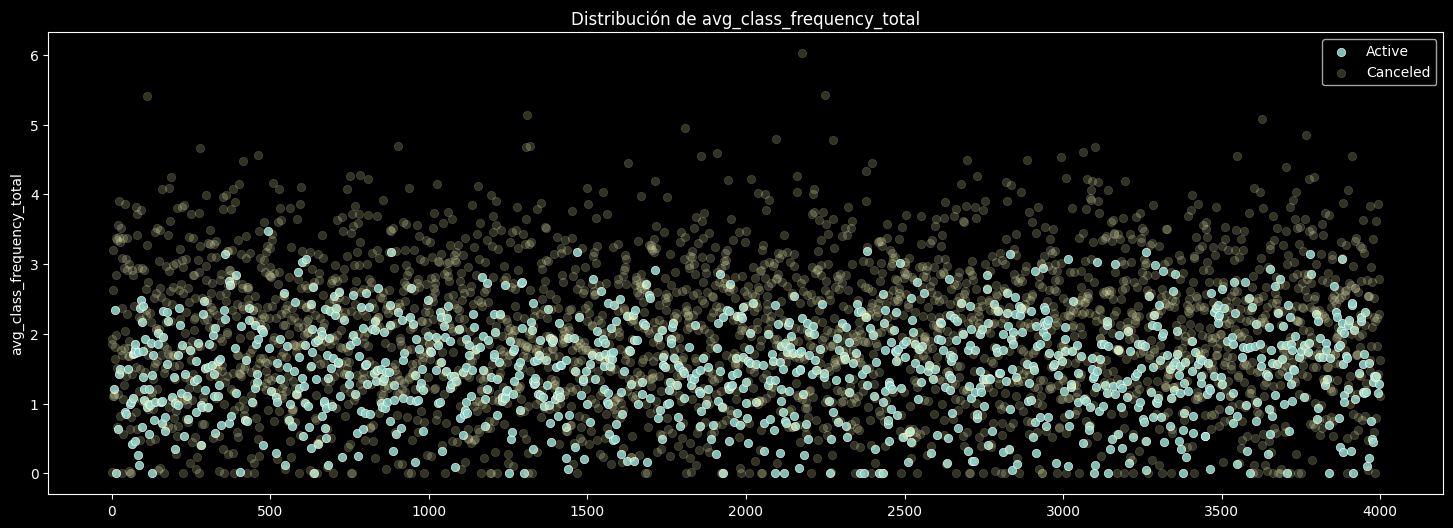

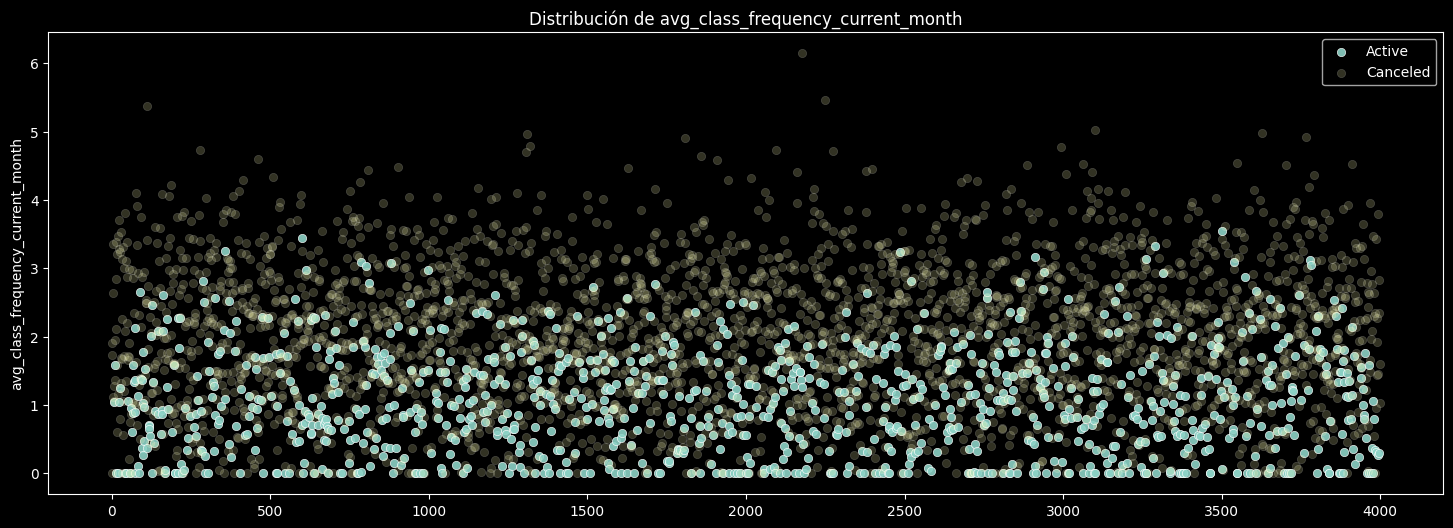

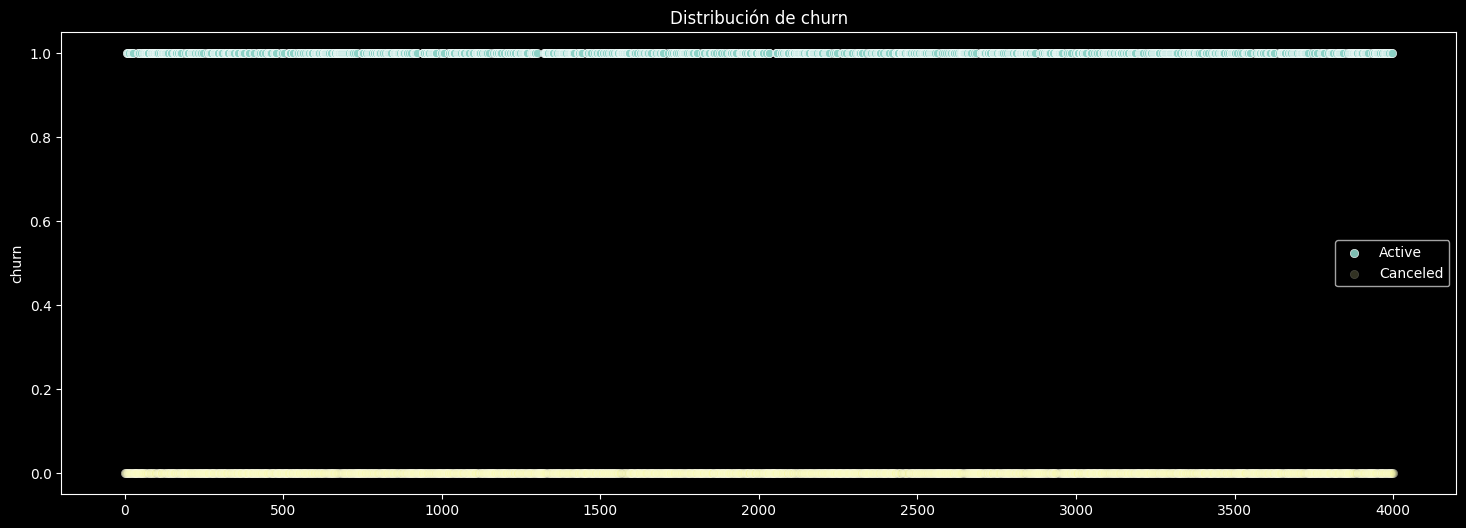

In [9]:
# scatters
for character in characteristics:
    plt.figure(figsize=(18,6))
    
    sns.scatterplot(active_users[character], label="Active", alpha=0.9)
    sns.scatterplot(canceled_users[character], label="Canceled", alpha=0.2)

    plt.title(f"Distribución de {character}")
    plt.legend()
    plt.show()

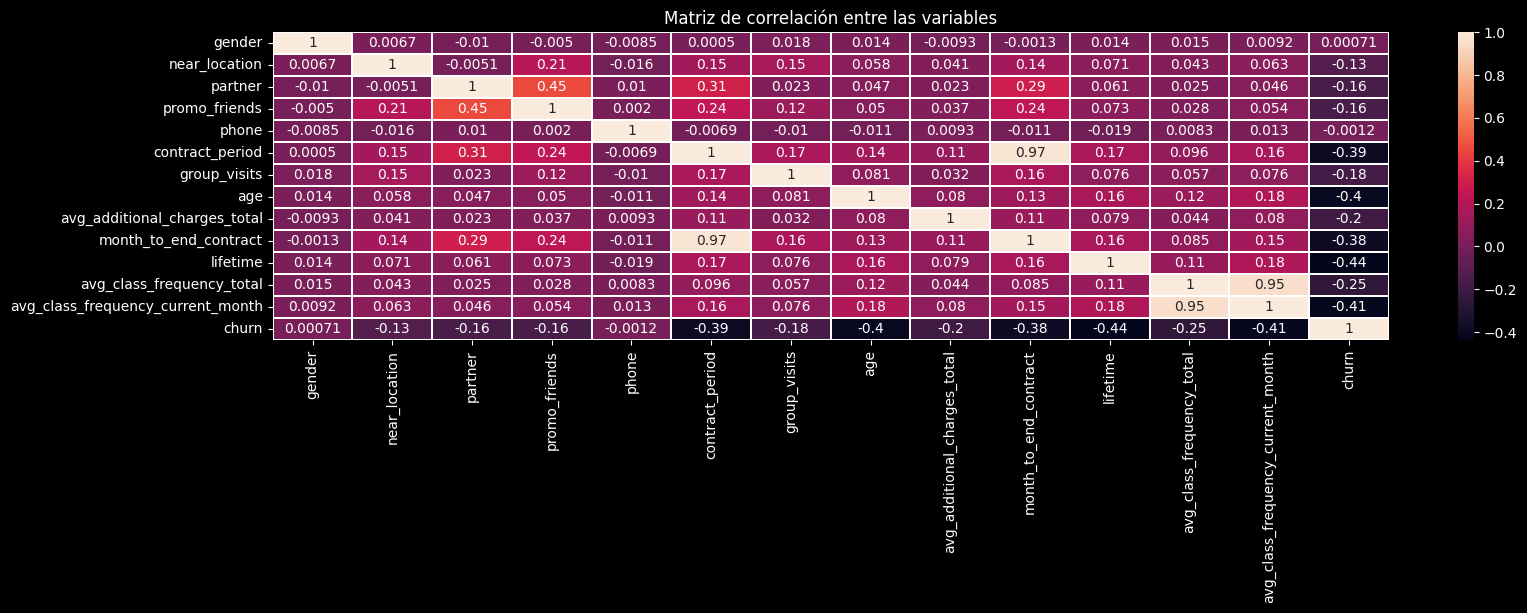

In [10]:
# matriz de correlación
matriz_corr = gym_data.corr()

plt.figure(figsize=(18,4))
sns.heatmap(matriz_corr,
            annot=True,
            linewidths=.2)
plt.title('Matriz de correlación entre las variables')
plt.show()

### Comentario:
De manera general, el DataFrame no presenta valores ausentes, los tipos de datos son correctos y no hay duplicados. Después de revisar la distribución general de las características encuentro que "contract_period", "additional_charges", "month_to_end" y "lifetime" presentaron mayor dispersión lo cual puede ser un <span style="color: skyblue;">**indicador para la segmentación de usuarios**</span>.

Los <span style="color: skyblue;">**usuarios activos parecen gastar más**</span> en otros servicios dentro de gimnasio que los que han cancelado.

Se tienen 4000 registros de usuarios en total y hay mayor cantidad de usuarios con cancelación. Las características para los grupos de usuarios activos y con cancelación <span style="color: skyblue;">**en su mayoría tienen la misma distribución, excepto por: "age" y "month_to_end"**</span>.

Finalmente la matriz de correlación muestra que las características se correlacionan con la variable objetivo de forma negativa (<span style="color: skyblue;">**a mayor presencia de la variable menor probabilidad de abandono**</span>). Las relaciones con mayor fuerza se presentan en "age", "lifetime" y "class_frecuency_current_month".

Se observó una <span style="color: skyblue;">**divergencia entre la correlación y el análisis de las medias para la categoría "age"**</span>, aquí es importante resaltar que aunque los usuarios que cancelan son un poco mayores en promedio, al analizar la edad completa se observa que las personas de mayor edad casi no cancelan. Esto invierte la tendencia global y explica por qué la correlación entre edad y churn es negativa.

<span style="color: skyblue;">**No parece haber multicolinealidad en las variables.**</span>

# Modelo para predecir cancelación

In [11]:
# dividir datos en entrenamiento y validación
x = gym_data.drop('churn', axis=1)
y = gym_data['churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [12]:
# función para métricas de modelos
def metrics(y_true, y_pred, y_proba, title = 'Métricas de clasificación'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [13]:
# estandarizar para modelo logistic regression
standard = StandardScaler()
x_train_st = standard.fit_transform(x_train)
x_test_st = standard.transform(x_test)

# modelo logistic regression
lr_model = LogisticRegression(random_state=0)
lr_model.fit(x_train_st, y_train)
lr_predict = lr_model.predict(x_test_st)
lr_probabilites = lr_model.predict_proba(x_test_st)[:,1]

# ajustar umbral
threshold = 0.2
lr_custom_predictions =  [0 if i<threshold else 1 for i in lr_probabilites]

In [14]:
# modelo random forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=0)
rf_model.fit(x_train, y_train)
rf_predict = rf_model.predict(x_test)
rf_probabilities = rf_model.predict_proba(x_test)[:,1]

# ajustar umbral
threshold = 0.2
rf_custom_predictions =  [0 if i<threshold else 1 for i in rf_probabilities]

In [15]:
# mostrar métricas
metrics(y_test, lr_custom_predictions, lr_custom_predictions, title='Metricas de LogisticRegression')
print()
metrics(y_test, rf_custom_predictions, rf_custom_predictions, title='Metricas de RandomForestClassifier')

Metricas de LogisticRegression
	Accuracy: 0.89
	Precision: 0.72
	Recall: 0.94
	ROC_AUC: 0.91

Metricas de RandomForestClassifier
	Accuracy: 0.86
	Precision: 0.66
	Recall: 0.96
	ROC_AUC: 0.90


### Comentario
Ambos modelos son buenos pero dado el objetivo: "identificar a los clientes en riesgo", se tiene que priorizar la métrica "Recall" por lo que <span style="color: skyblue;">**el algoritmo "RandomForestClassifier" es mejor para la tarea**</span>.

<span style="color: orange;">**Nota:**</span> se tuvo que ajustar el umbral ya que en los datos hay una mayor cantidad de usuarios con cancelación y de esta forma mejorar el "Recall".

# Crear clústers de usuarios

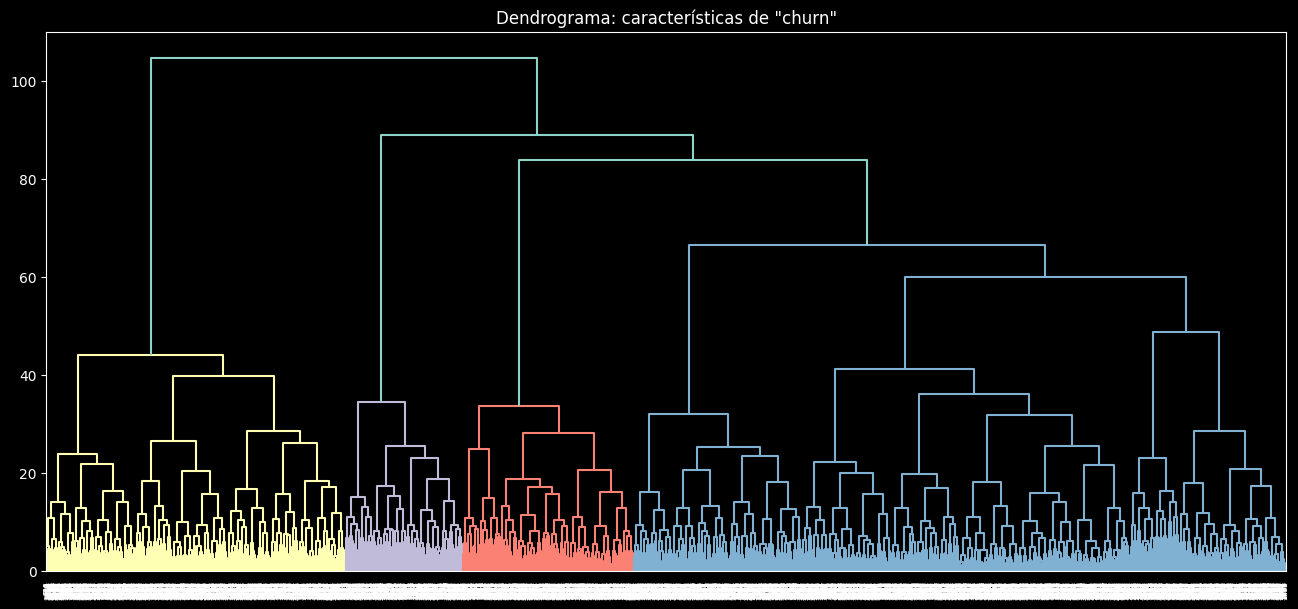

In [ ]:
# crear una matriz de distancias y un dendrograma
# matriz de distancias
st = StandardScaler()
x_st = st.fit_transform(x)
linked = linkage(x_st, method='ward')

# dendrograma
plt.figure(figsize=(16, 7))
dendrogram(linked, orientation='top')
plt.title('Dendrograma: características de "churn"')
plt.show()

In [17]:
# elaborar clústers
km = KMeans(n_clusters=5)
labels = km.fit_predict(x_st)

# agregar etiquetas al df
gym_data['labels'] = labels

# medias de las características para los clústers
clusters = gym_data.groupby('labels').mean()
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
labels,,,,,,,,,,,,,,
0,0.483138,0.739003,0.371701,0.173021,1.000000,1.642229,0.269062,27.935484,128.122976,1.573314,2.043988,1.240279,0.970049,0.593842
1,0.546939,0.877551,0.275510,0.196939,1.000000,1.944898,0.459184,30.024490,156.853505,1.859184,4.666327,2.629265,2.610225,0.103061
2,0.458716,0.917431,0.775229,0.496942,0.995413,10.357798,0.487768,29.920489,158.635505,9.373089,4.567278,2.834977,2.832524,0.019878
3,0.554662,0.942122,0.781350,0.590032,0.995177,9.699357,0.569132,29.768489,162.701759,8.898714,4.963023,1.111339,1.097764,0.054662
4,0.528947,0.860526,0.465789,0.297368,0.000000,4.663158,0.418421,29.276316,143.027956,4.363158,3.852632,1.848240,1.715155,0.271053


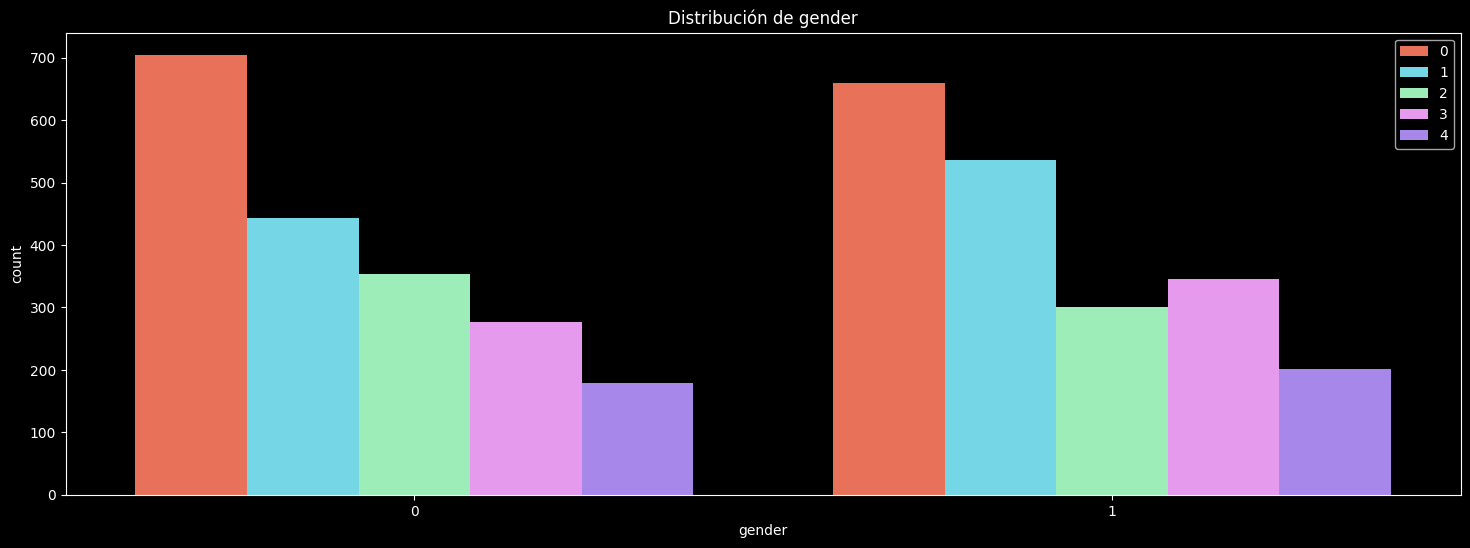

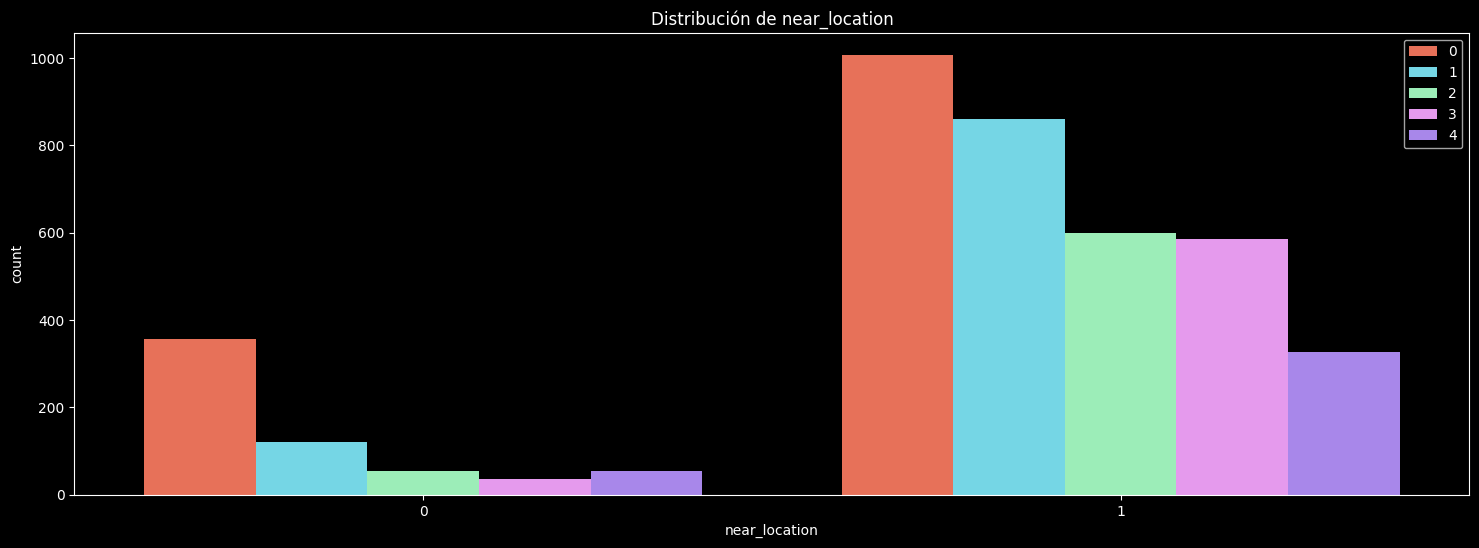

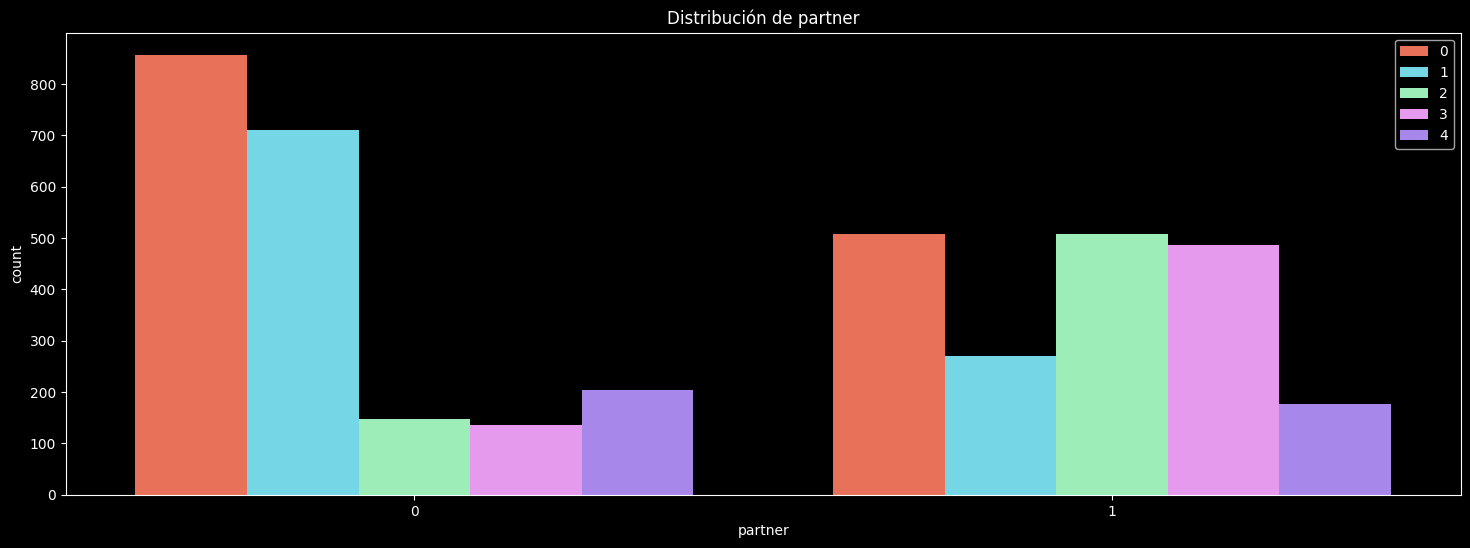

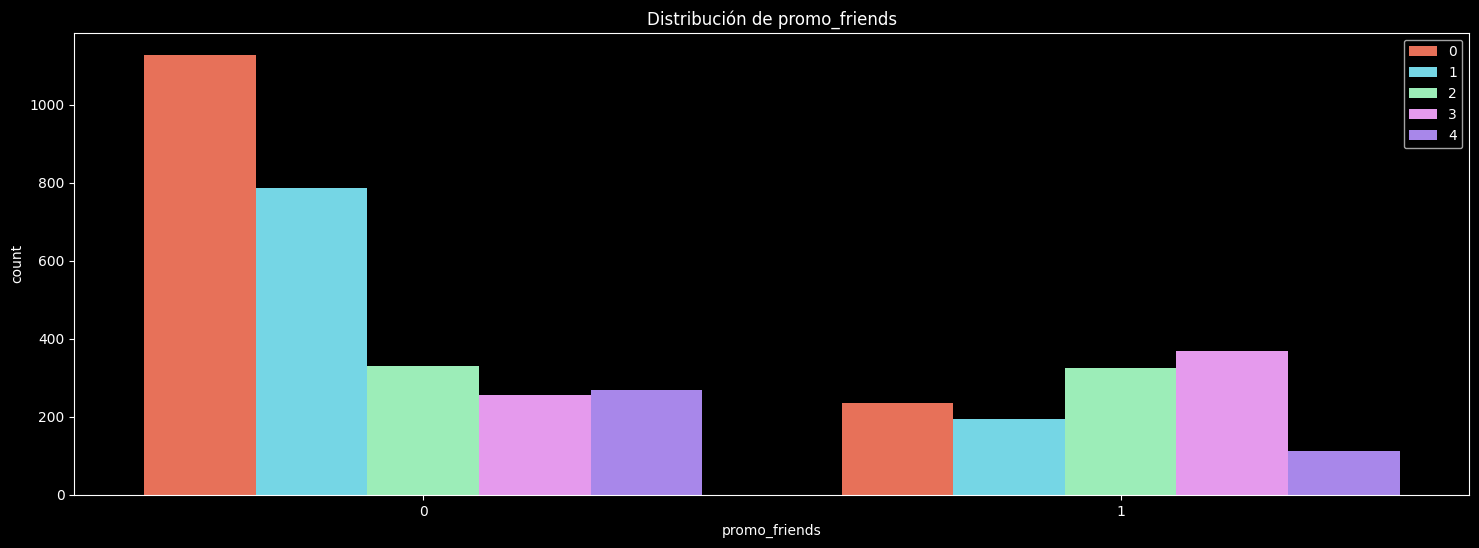

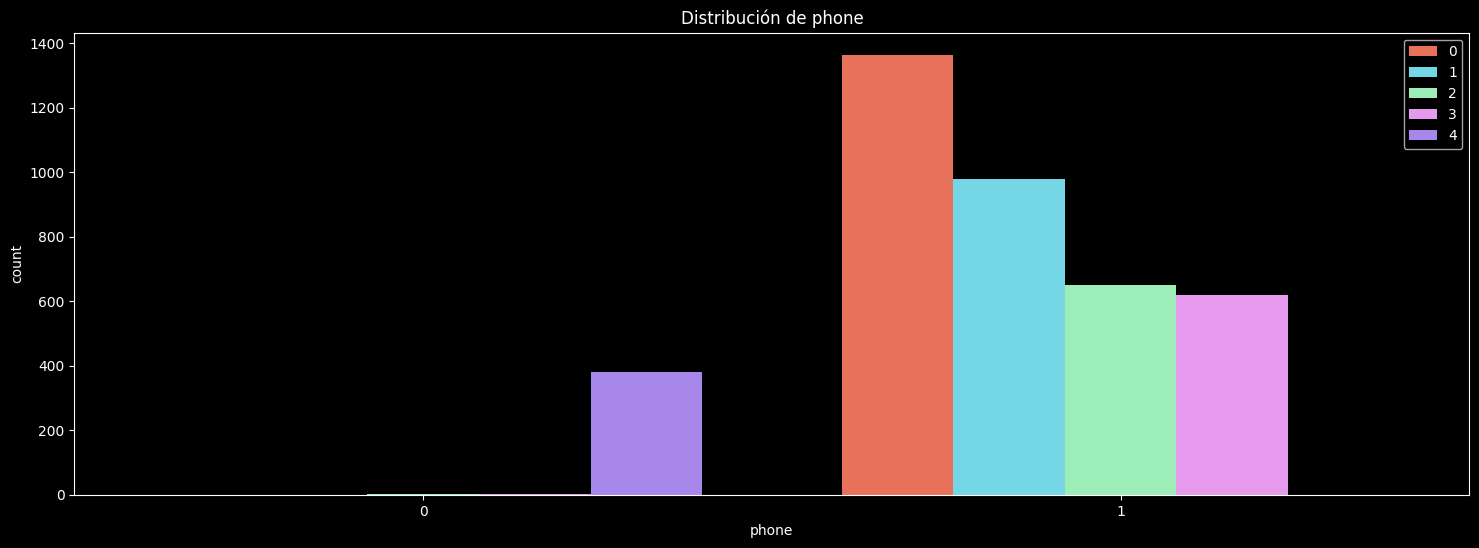

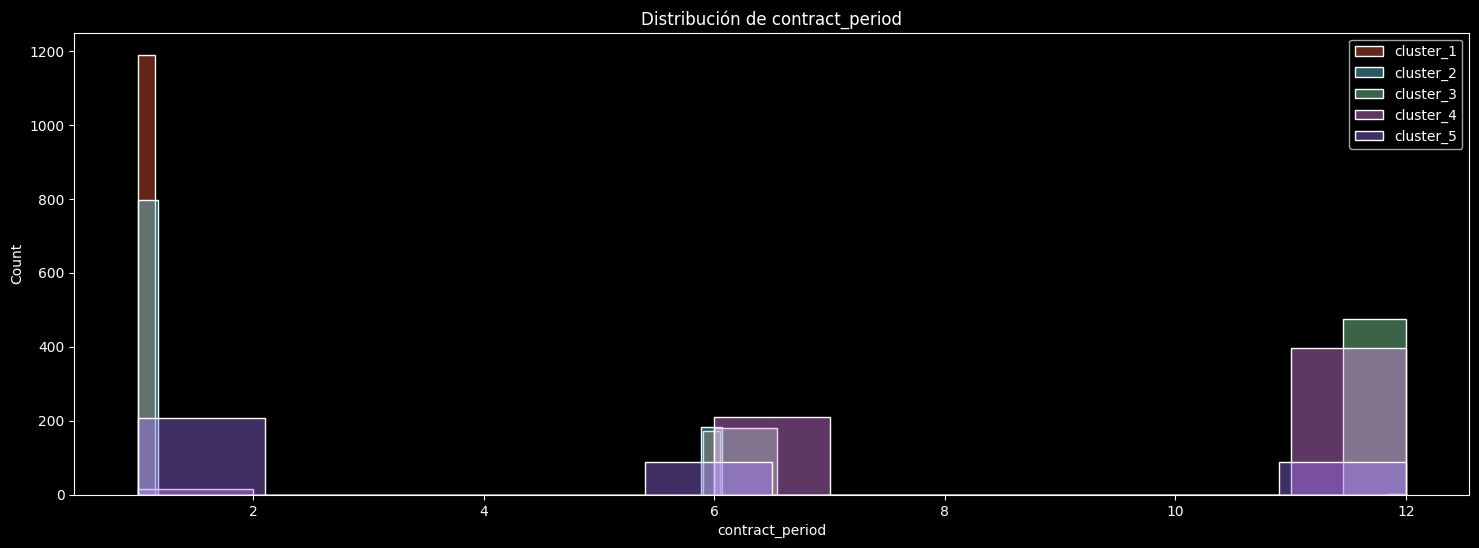

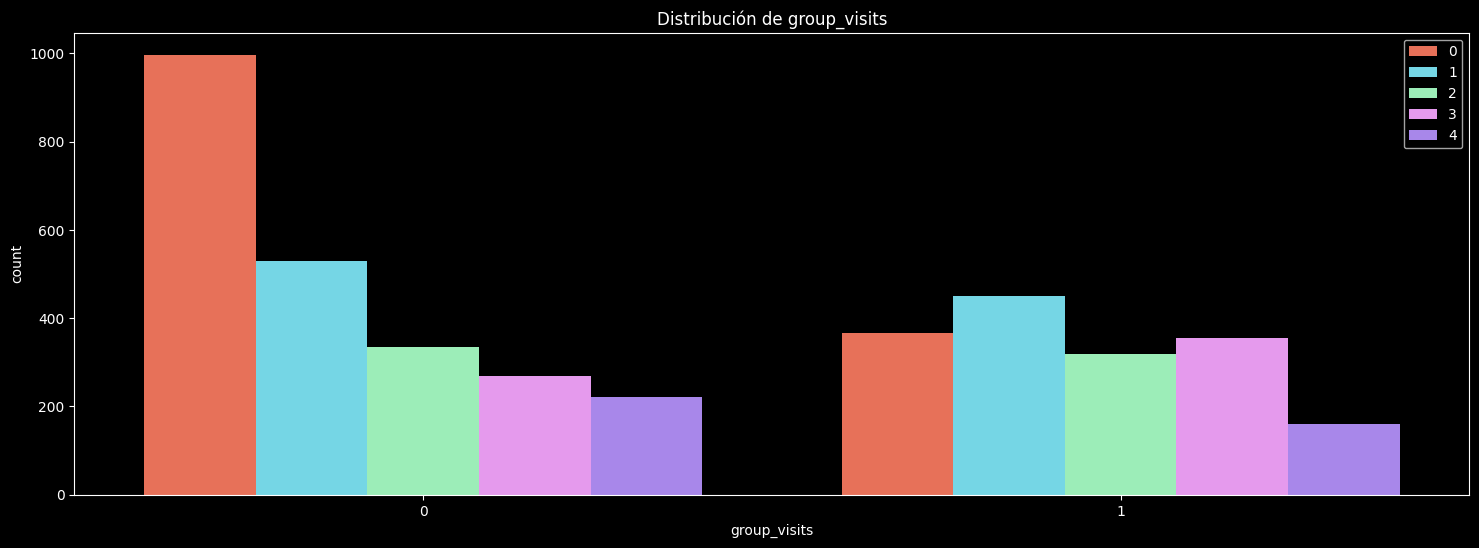

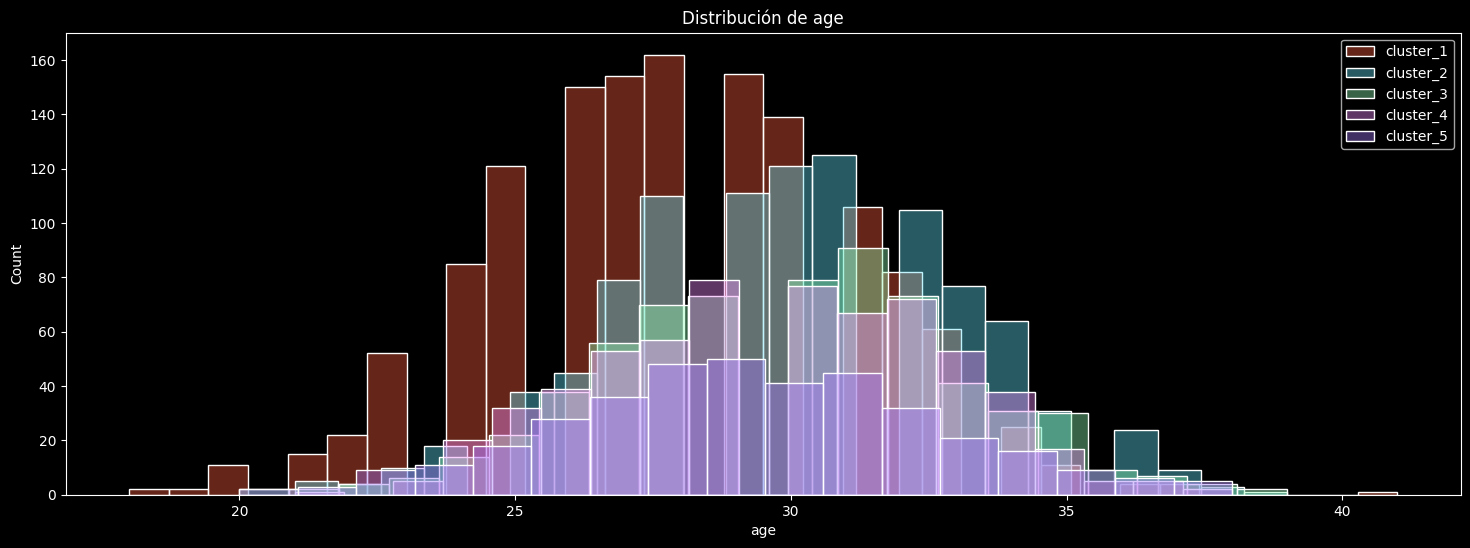

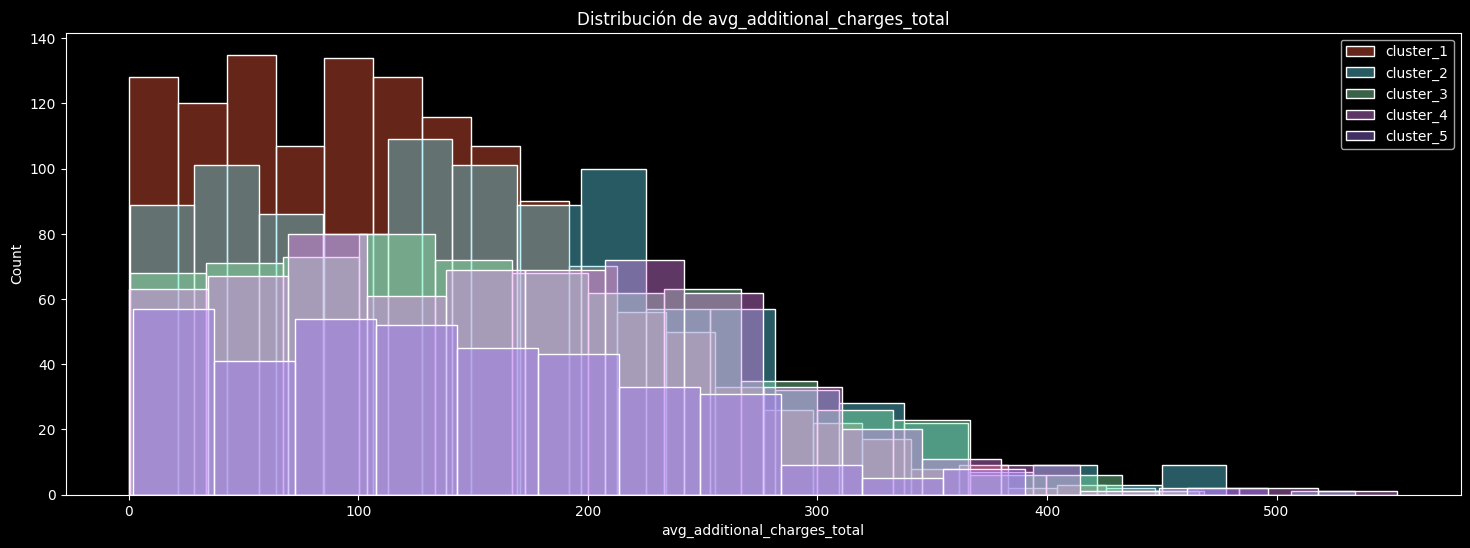

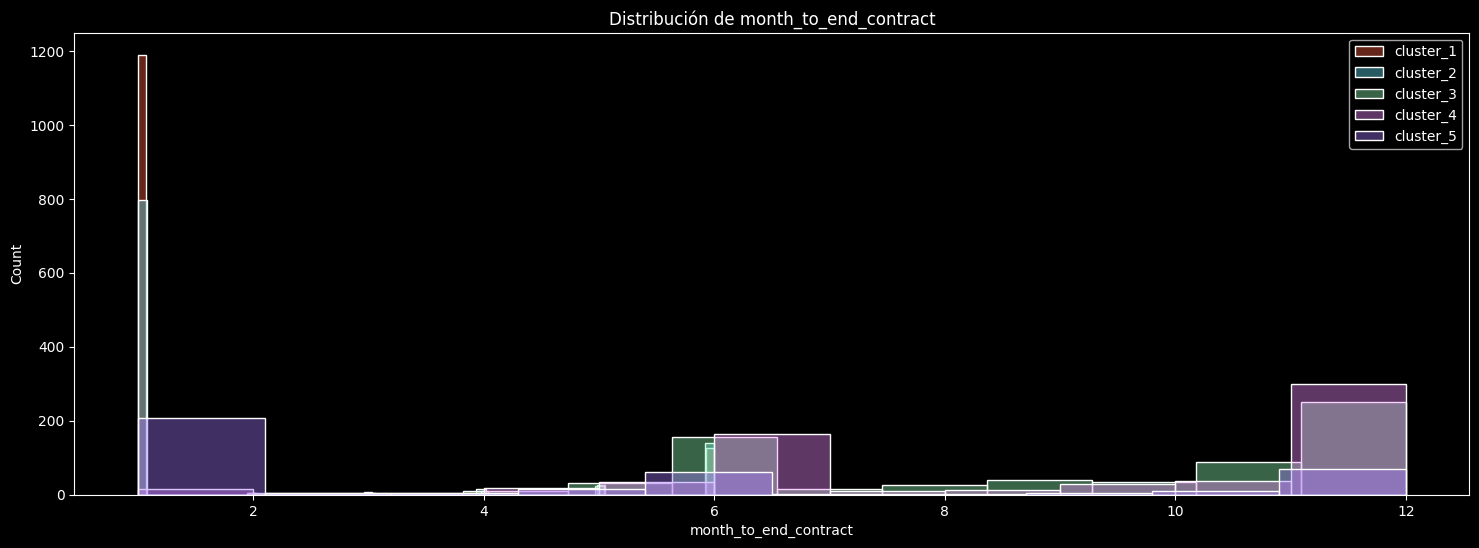

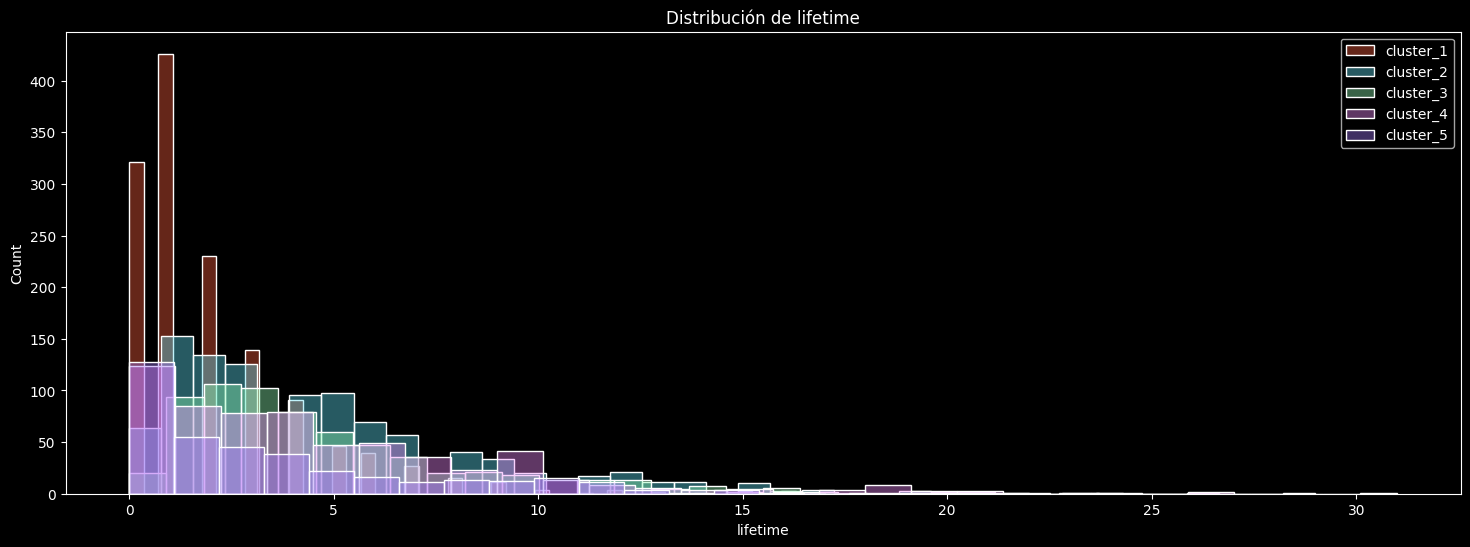

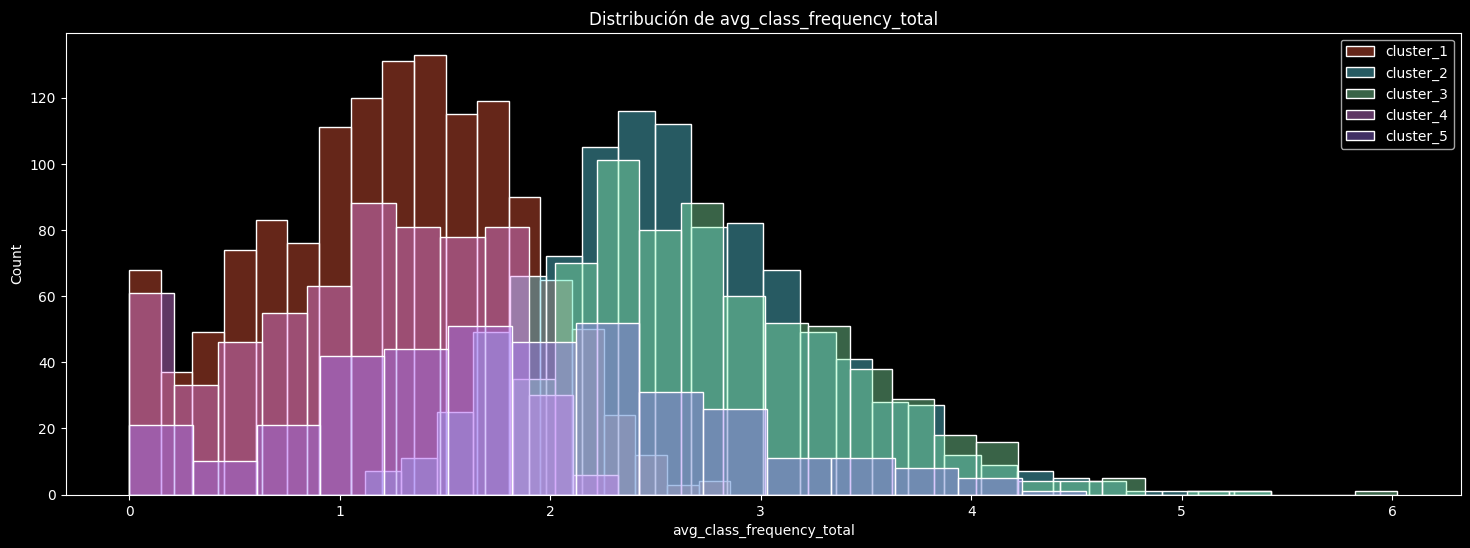

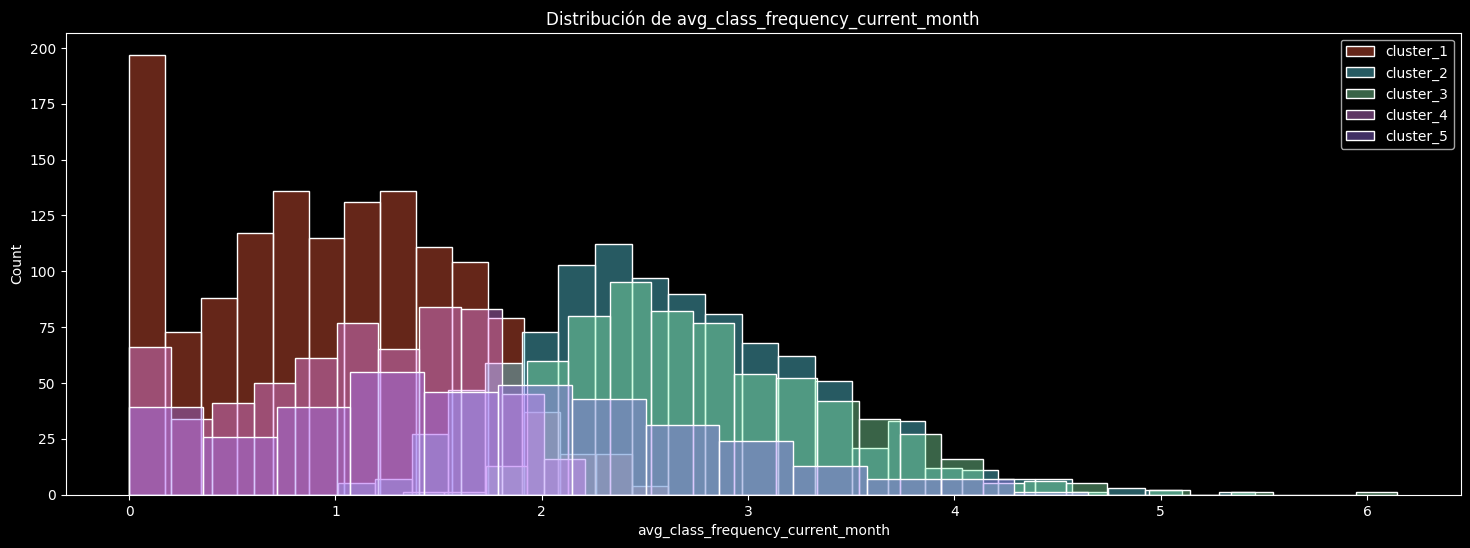

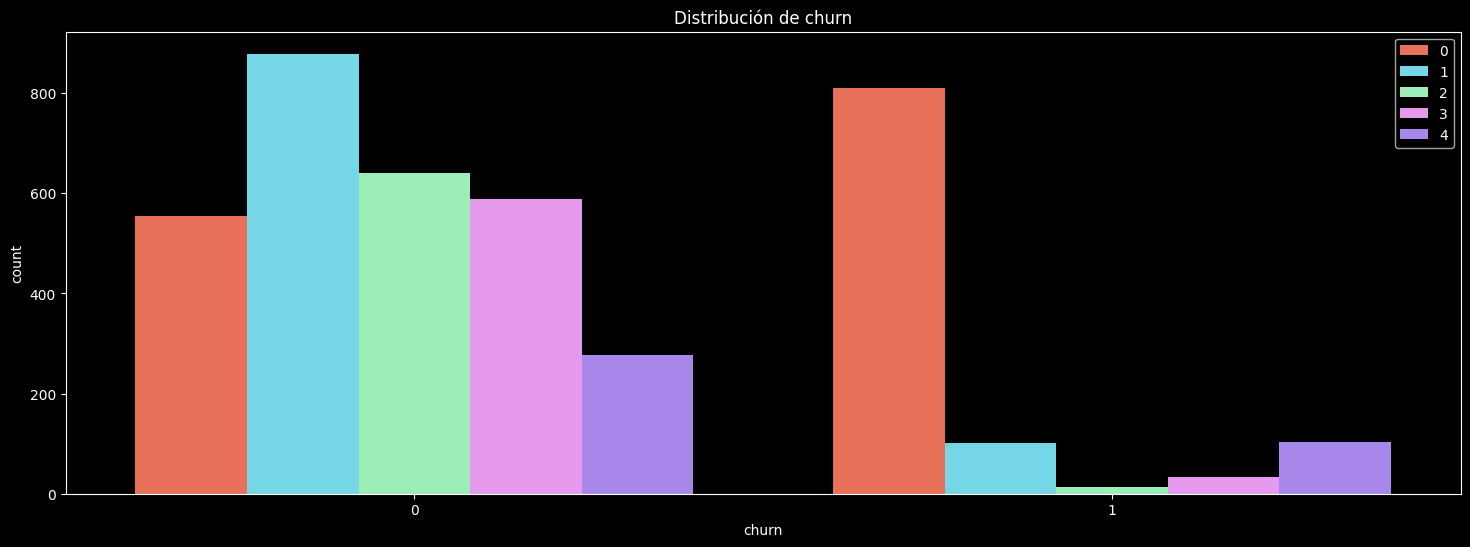

In [18]:
# dividir por grupos
cluster_0 = gym_data.query('labels == 0')
cluster_1 = gym_data.query('labels == 1')
cluster_2 = gym_data.query('labels == 2')
cluster_3 = gym_data.query('labels == 3')
cluster_4 = gym_data.query('labels == 4')
clusters = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4]

# colores para los 5 clusters
colors = ["#FF6141", "#63E3F7", '#8FFAB4', "#F08CFB", "#A276FA"]

# distribuciones para los clústers
for character in characteristics:
    plt.figure(figsize=(18, 6))
        
    # Gráfica para variables categóricas
    if gym_data[character].nunique() <= 2:
        sns.countplot(data=gym_data, x=character, hue='labels', palette=colors)
    
    # Gráfica para numéricas
    else:
        for i, cluster in enumerate(clusters):
            sns.histplot(
                cluster[character],
                label = f"cluster_{i+1}",
                color=colors[i],
                alpha=0.4
            )

    plt.title(f"Distribución de {character}")
    plt.legend()
    plt.show()

In [19]:
# tasa de cancelación para cada clúster
cancalation_rate = gym_data.groupby('labels')['churn'].mean()

print(cancalation_rate.sort_values(ascending=False))

labels
0    0.593842
4    0.271053
1    0.103061
3    0.054662
2    0.019878
Name: churn, dtype: float64


### Comentario
Se formaron 5 grupos en donde <span style="color: skyblue;">**el 3 y 0 muestran mayor tasa de cancelación**</span>, revisando las distribuciones y las medias me puedo percatar que se separan de forma importante del resto. Hay que revisar las <span style="color: skyblue;">**características con mayor relación a "churn" y contrastarlas con las de estos grupos**</span>.